# 이미지 특징 추출


이번 절에서는 이미지에서 라인, 코너, 특징점 등과 같은 특징 추출(feature extraction) 방법을 공부한다.

## 이미지 미분

가로/세로 위치 변화에 따른 픽셀 값의 변화율을 이미지의 도함수(Image derivatives)라고 한다. 다음 식에서 $f(x)$는 $x$위치의 픽셀 명도이다.

$$ g_x = \dfrac{\partial f}{\partial x},\;\; g_y = \dfrac{\partial f}{\partial y} $$

$x,y$ 방향의 도함수의 크기를 구하는 것이 라플라스 연산이다.

$$ g = \sqrt{{g_x}^2 + {g_y}^2} $$

실제 이미지 프로세싱에서는 다음과 같은 중앙차분법(central difference)을 사용한다.

$$
G(x) = f(x+1) - f(x-1) \approx \begin{bmatrix}-1 & 0 & 1 \end{bmatrix}
$$

이 연산은 다음 이미지 커널를 사용하여 필터링한 것과 같다.

$$ k = [1, 0, -1] $$



## 엣지 추출

경계선을 인지하는 것 엣지 추출(edge detection)이라고 한다.  엣지(경계선)는 이미지 안에서 픽셀의 값이 갑자기 변하는 곳이다. 따라서 엣지 추출을 하는 알고리즘은 이미지를 미분한 그레디언트(gradient) 벡터의 크기로 판단한다. 
대표적인 엣지 추출 알고리즘으로 Sobel edge Detection과 Canny edge Detection이 있다.

OpenCV에서 Sobel edge Detection `Sobel`, `Laplacian` 명령으로 구현한다.

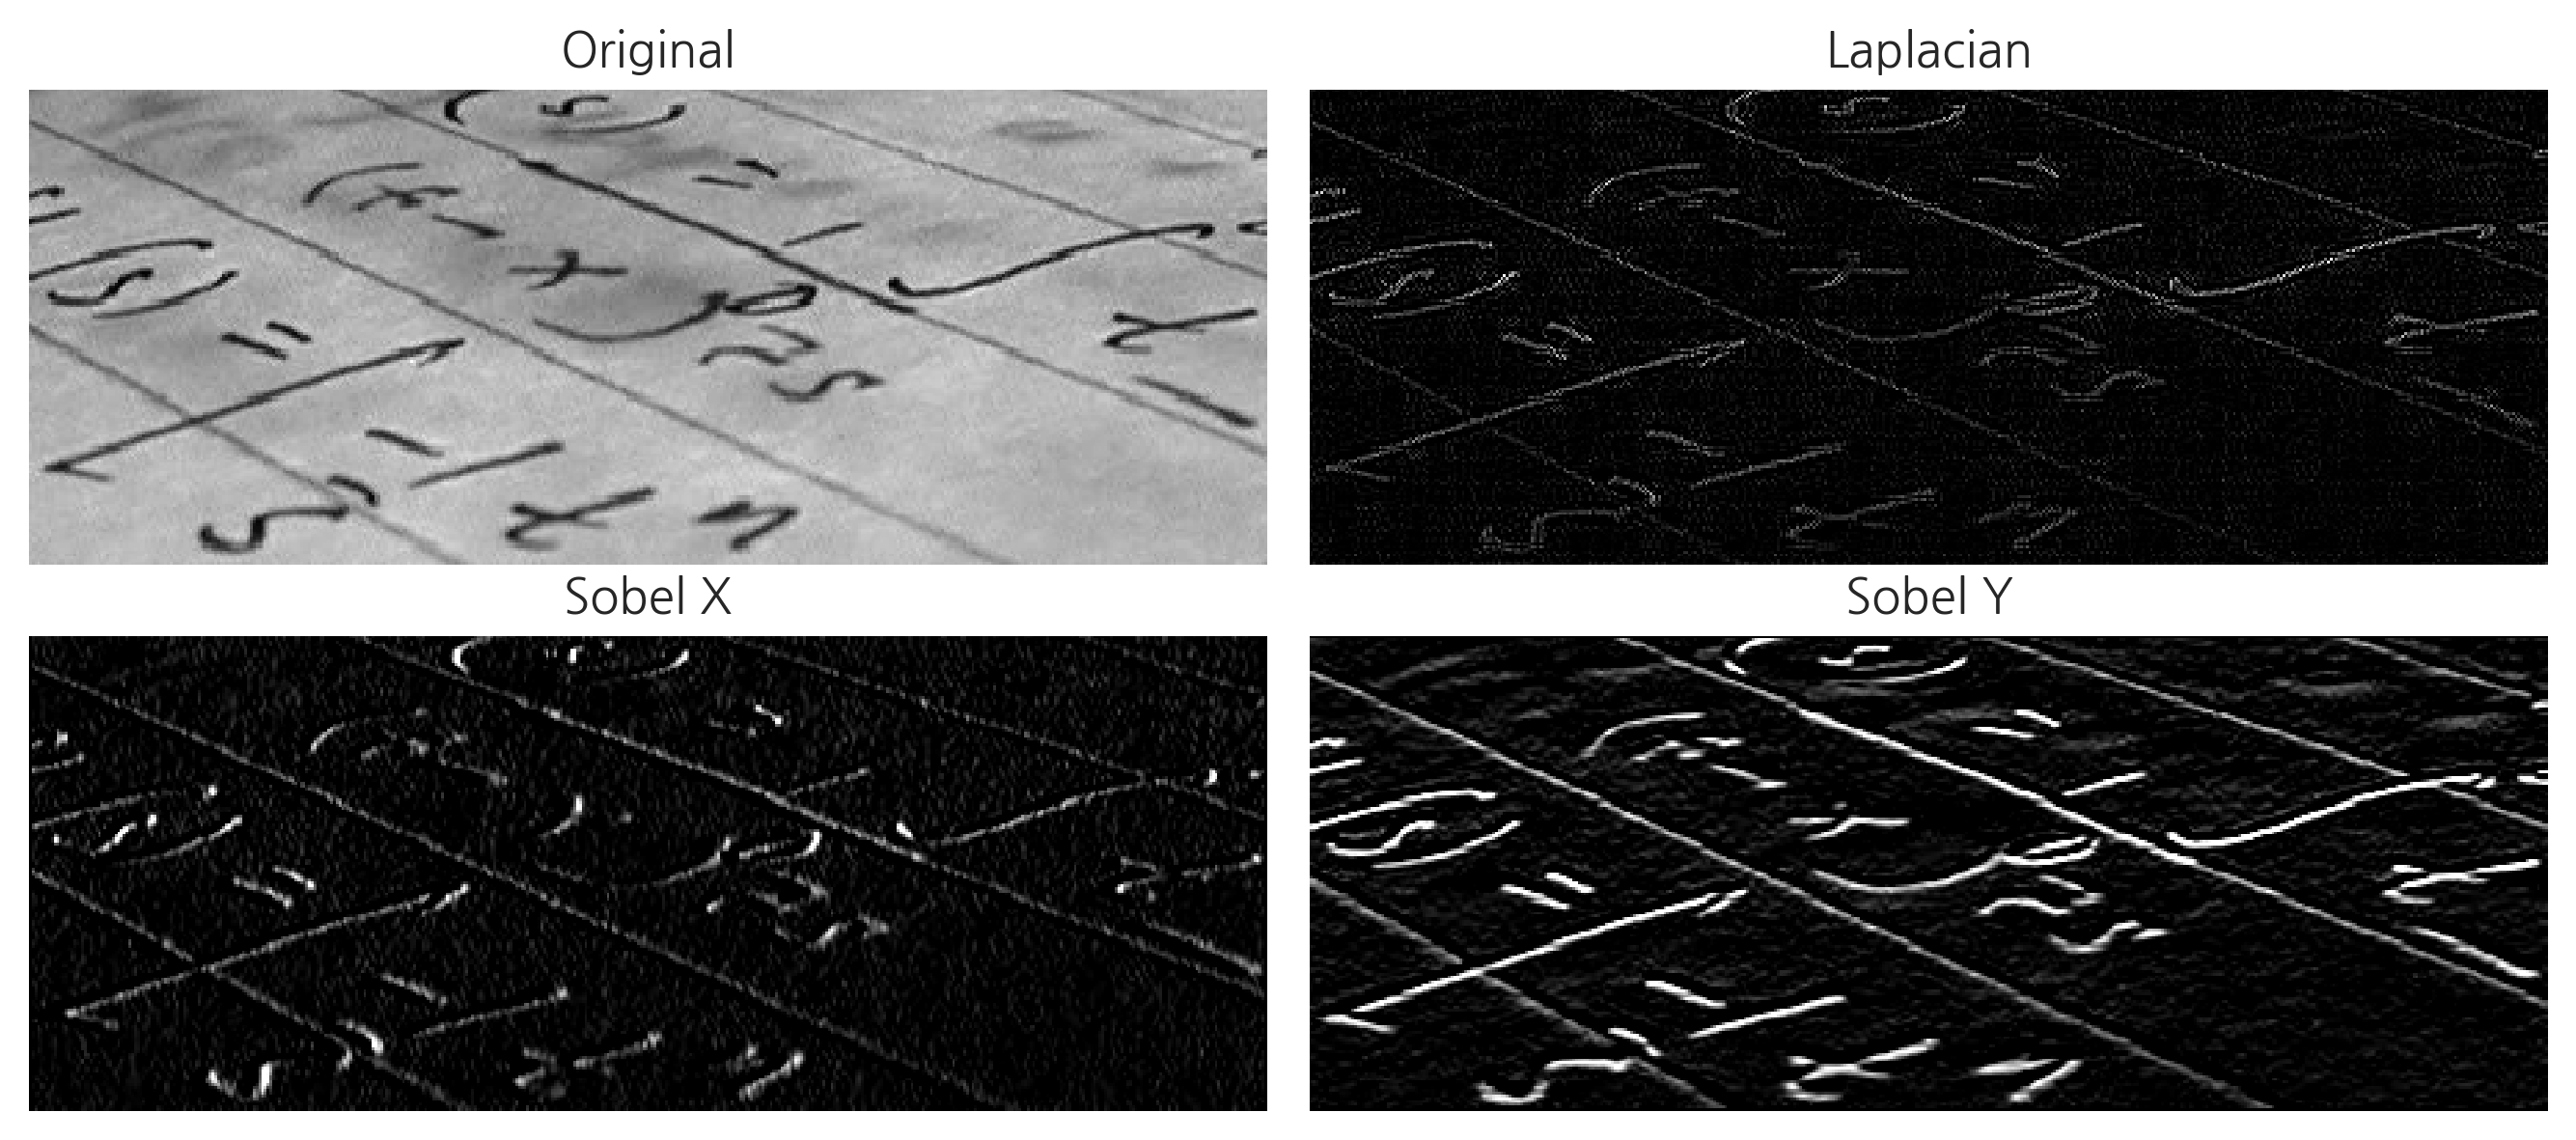

In [1]:
from skimage.data import text
import cv2

img = text()

sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
laplacian = cv2.Laplacian(img, cv2.CV_8U)

plt.figure(figsize=(9, 4))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian')
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')
plt.axis("off")
plt.tight_layout()
plt.show()

## 캐니 엣지 추출

캐니 엣지 추출법은 그레디언트의 크기 뿐 아니라 방향도 사용한다. 또한 국부 최대값 근처의 그레디언트값을 제거하는 Nonmaximal suppression을 이용하여 가짜 엣지를 제거한다. 마지막으로 두 개의 기준값(threshold)을 사용해서 엣지를 구분한다.
      
아래 코드는 `canny` 함수를 사용하여 이미지의 엣지를 추출한다. 기준값으로는 50과 100을 사용하였다.

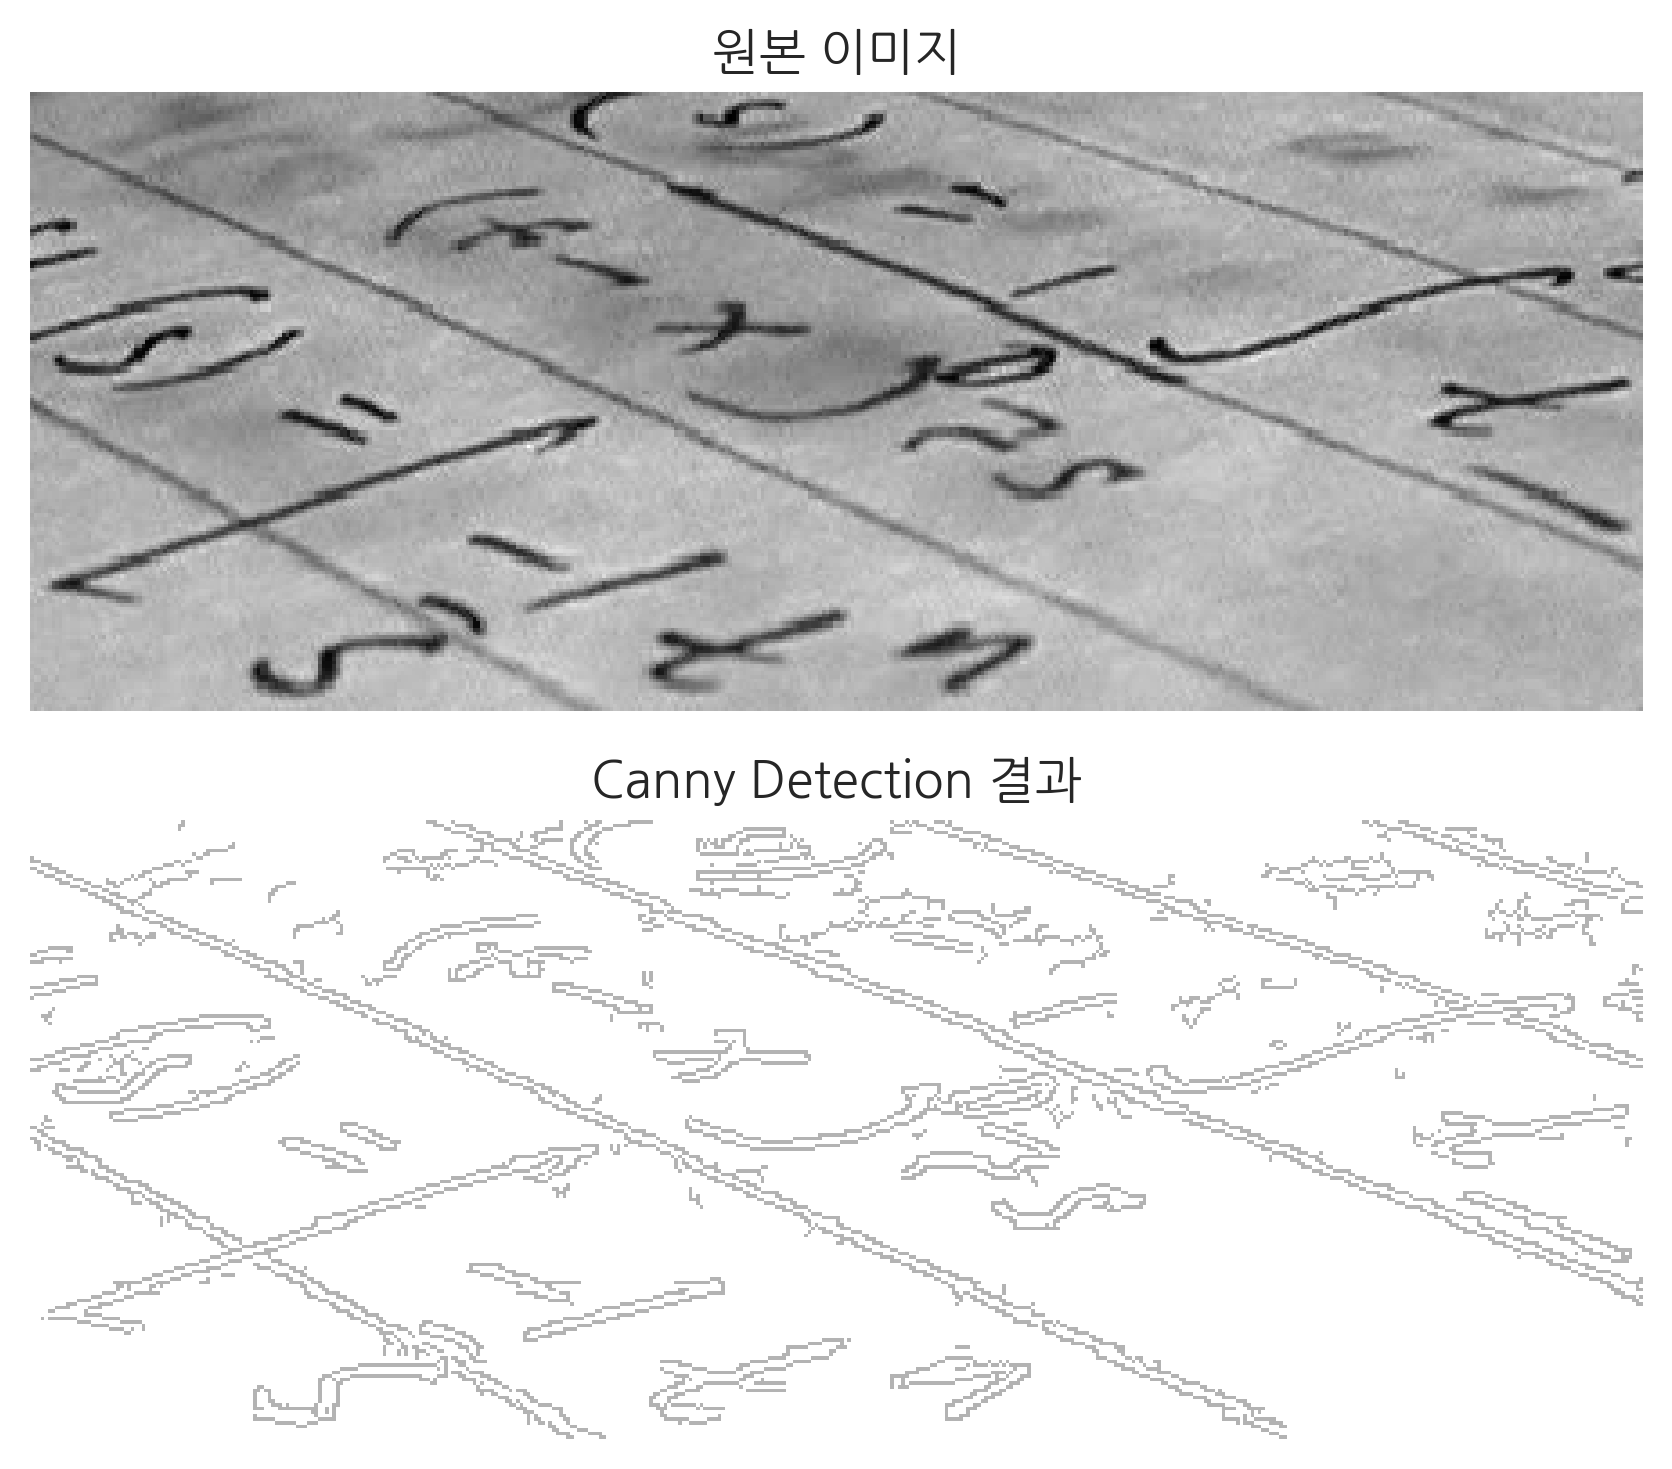

In [2]:
img = text()
edges = cv2.Canny(img, 50, 100)

plt.subplot(2, 1, 1)
plt.imshow(img, cmap="gray")
plt.title("원본 이미지")
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(edges, cmap="Greys", alpha=0.3)
plt.axis('off')
plt.title("Canny Detection 결과")
plt.tight_layout()
plt.show()

## 코너 추출

코너(Corner)는 엣지가 교차되는 점이다. 

## 해리스 코너 추출

해리스 코너 추출 함수 `cornerHarris`는 이미지 위에 커널을 이동시키면서 그레디언트의 변화량을 구하고 이 값을 적절한 기준값으로 구별하여 코너점을 찾는다.

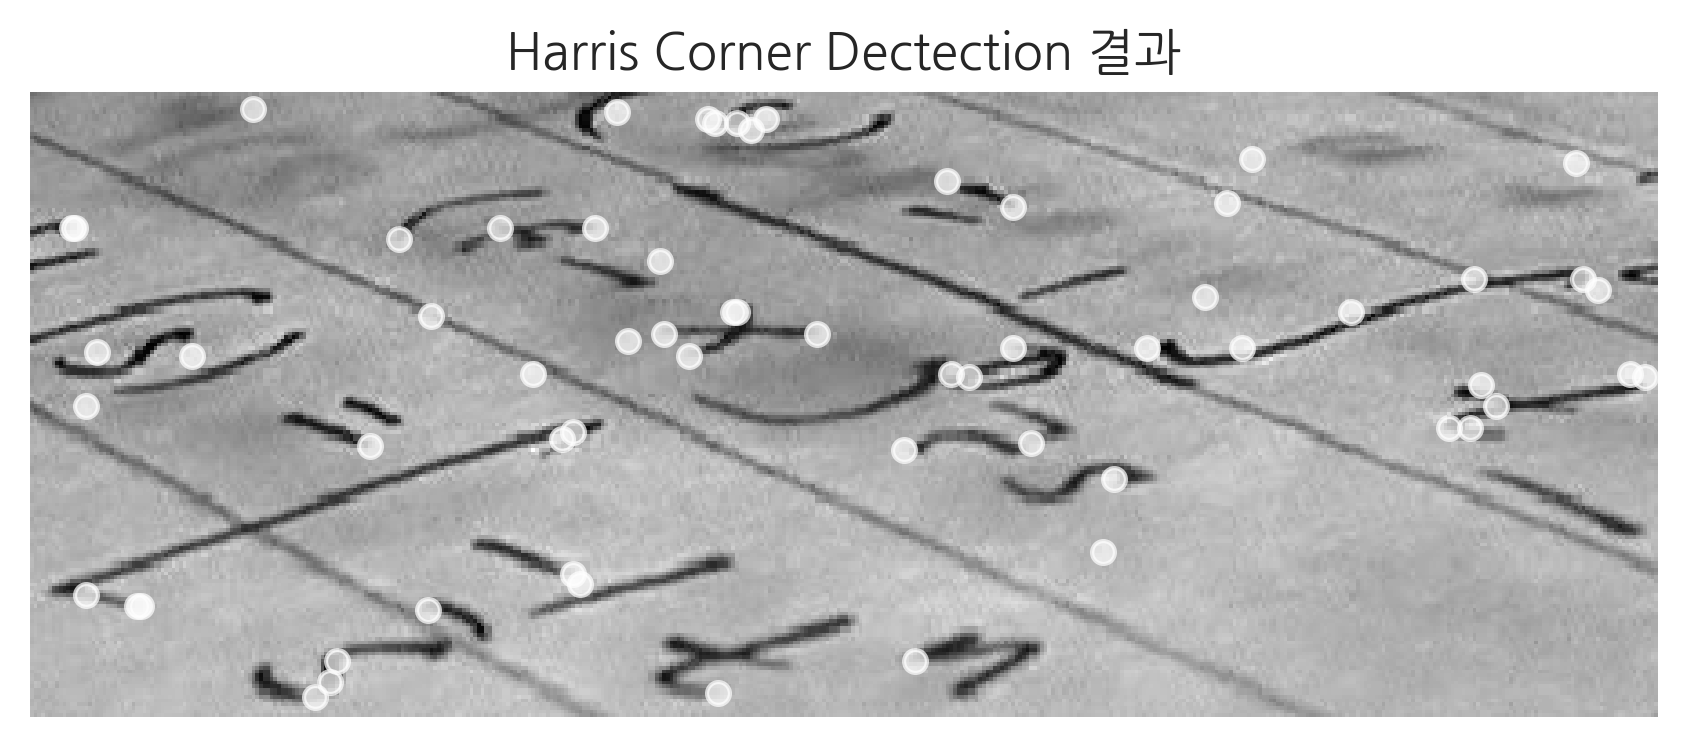

In [3]:
dst = cv2.cornerHarris(img, 2, 3, 0.24)

# thresholding
ret, dst = cv2.threshold(dst, 0.001 * dst.max(), 1, 0)

x, y = np.nonzero(dst)

plt.figure(figsize=(7,7))
plt.title("Harris Corner Dectection 결과")
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.scatter(y, x, s=30, c="w", alpha=0.7)
plt.show()

## Shi & Tomasi 코너 추출

Harris 코너 추출법은 모든 방향으로 그레디언트의 변화량이 큰 지점을 코너라고 판단하지만 Shi & Tomasi 코너 추출법은  더 작은 변화를 보이는 방향의 변화량이 설정한 기준값보다 크면 코너라고 판단한다. OpenCV에서 `goodFeatureToTrack`이라는 메서드로 구현되어 있다.

`goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance)`

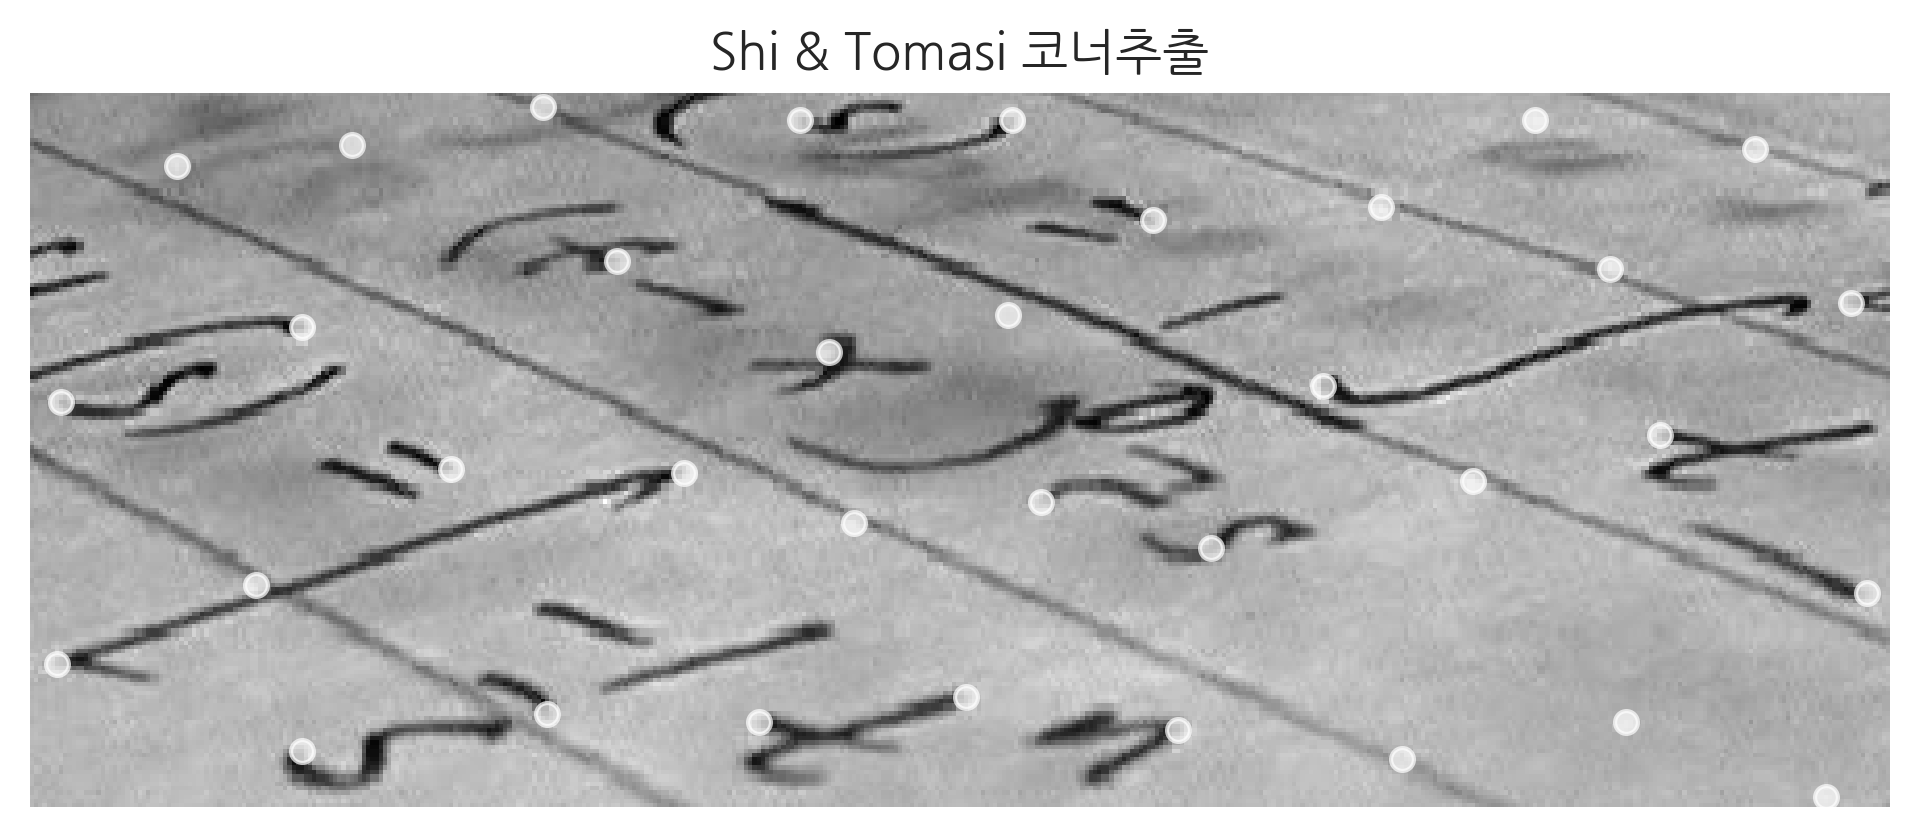

In [4]:
corners = cv2.goodFeaturesToTrack(img, 100, 0.001, 40)
corners = np.int0(corners)

plt.title("Shi & Tomasi 코너추출")
plt.imshow(img, cmap="gray")
plt.scatter(corners[:, 0, 0], corners[:, 0, 1], s=30, c="w", alpha=0.7)
plt.axis("off")
plt.show()

## 허프 라인 변환

허프 라인 변환(Hough line transformation)을 사용하면, 검출된 엣지로부터 직선을 이루는 부분을 찾아낼 수 있다. 

이미지에서 한 좌표 $(x_1, y_1)$ 가 주어졌을 때, 그 좌표를 지나는, 기울기 $m$ 과, $y$ 절편 $c$ 를 가지는 직선의 방정식 $y_1 = m x_1 + c$를 정의할 수 있다. 이 때, 이 직선이 많은 엣지 좌표들을 지난다면, 그것이 이미지에 있는 직선일 확률이 높다. 한 좌표를 지나는 직선은 무한히 정의 할 수 있다. Hough Line 변환에서는 주어진 좌표를 지나는 직선을 1도 단위로 180도까지 회전시켜 180개의 2차원 배열을 만든다. 그리고 모든 점에 대해 이 연산을 수행해, 기준 값 이상의 점들을 지나는 직선의 방정식을 구한다. 이 연산을 위해, 위 직선의 방정식을 다음과 같은 극 좌표계에 나타낸다. 

$$
\\y = \left ( -\dfrac{\cos \theta}{\sin \theta} \right ) x + \left ( \dfrac{r}{\sin \theta} \right )
$$

<img src="https://datascienceschool.net/upfiles/2b30c93477674bc080e3eea5a8a78b4b.png" width="100%">

그림 38.3 : 주어진 좌표($x,y$)를 지나는 직선, 원점과의 거리($r$), 그리고  각도($\theta$)

이렇게 표현하면, 원점과 직선사이의 거리인 $r$ 을 다음 식 처럼 나타낼 수 있다. 

$$
r = \cos\theta \ x + \sin\theta \ y
$$

$x$와 $y$는 고정되어 있고, $\theta$ 값을 변화 시켜, $(r, \theta)$쌍을 만들면, 결과로 2차원 배열을 얻을 수 있다. 

이제 모든 점에 대해 이 연산을 수행하고, 기준값 보다 많은 점에서 교차되는 지점의 $(r, \theta)$ 값이 직선이 될 확률이 높은 지점이다. 같은 각도에서 원점에서의 거리가 같다는 것음 그 점들이 그 직선의 방정식 위에 존재한다는 의미이니 쉽게 이해가 될 것 이다. 이제 $(r, \theta)$값을 알고 있으니, 위의 극좌표계에서의 직선의 방정식에 대입하면, 이미지에서의 직선일 확률이 높은 직선의 방정식을 찾을 수 있다.

이 방법론은 타원, 사각형, 원을 추출할 때도 사용될 수 있다. 

OpenCV에서는 이 알고리즘을 `HoughLine` 이라는 함수로 구현해 놓았다.

* 파라미터
    - 검출한 엣지
    - $r$값을 정의하는 픽셀 수, 보통 1픽셀을 사용한다. 
    - $\theta$값을 정의하는 단위, 보통 1도를 사용한다. $r$을 1로 설정하면 해당 파라미터는 $\pi / 180$ 으로 설정한다.
    - 기준값(threshold), 직선이 교차하는 점의 최소 갯수를 의미한다. 

입력하면 엣지로 부터 직선을 추출한다. 

HoughLine 방법은 연산량이 너무 많기 때문에 보통은 확률적 Hough Transfomation 방법을 사용한다. 확률적 Hough Transfomation 방법은 모든 점이 아닌 임의의 점에 대해 $(r, \theta)$를 계산하는 것이다.  `HoughLineP`라는 이름으로 구현되어 있다. 이때는 파라미터로 `minLineLenght`(직선의 최소 길이), `maxLineGap`(같은 선 내에 있는 점들의 최소 간격)이 추가된다. 

다음 코드는 Canny Detection 방법으로 엣지를 추출하고, 추출한 엣지로 부터 `HoughLineP` 함수를 사용해 직선을 추출한다. 

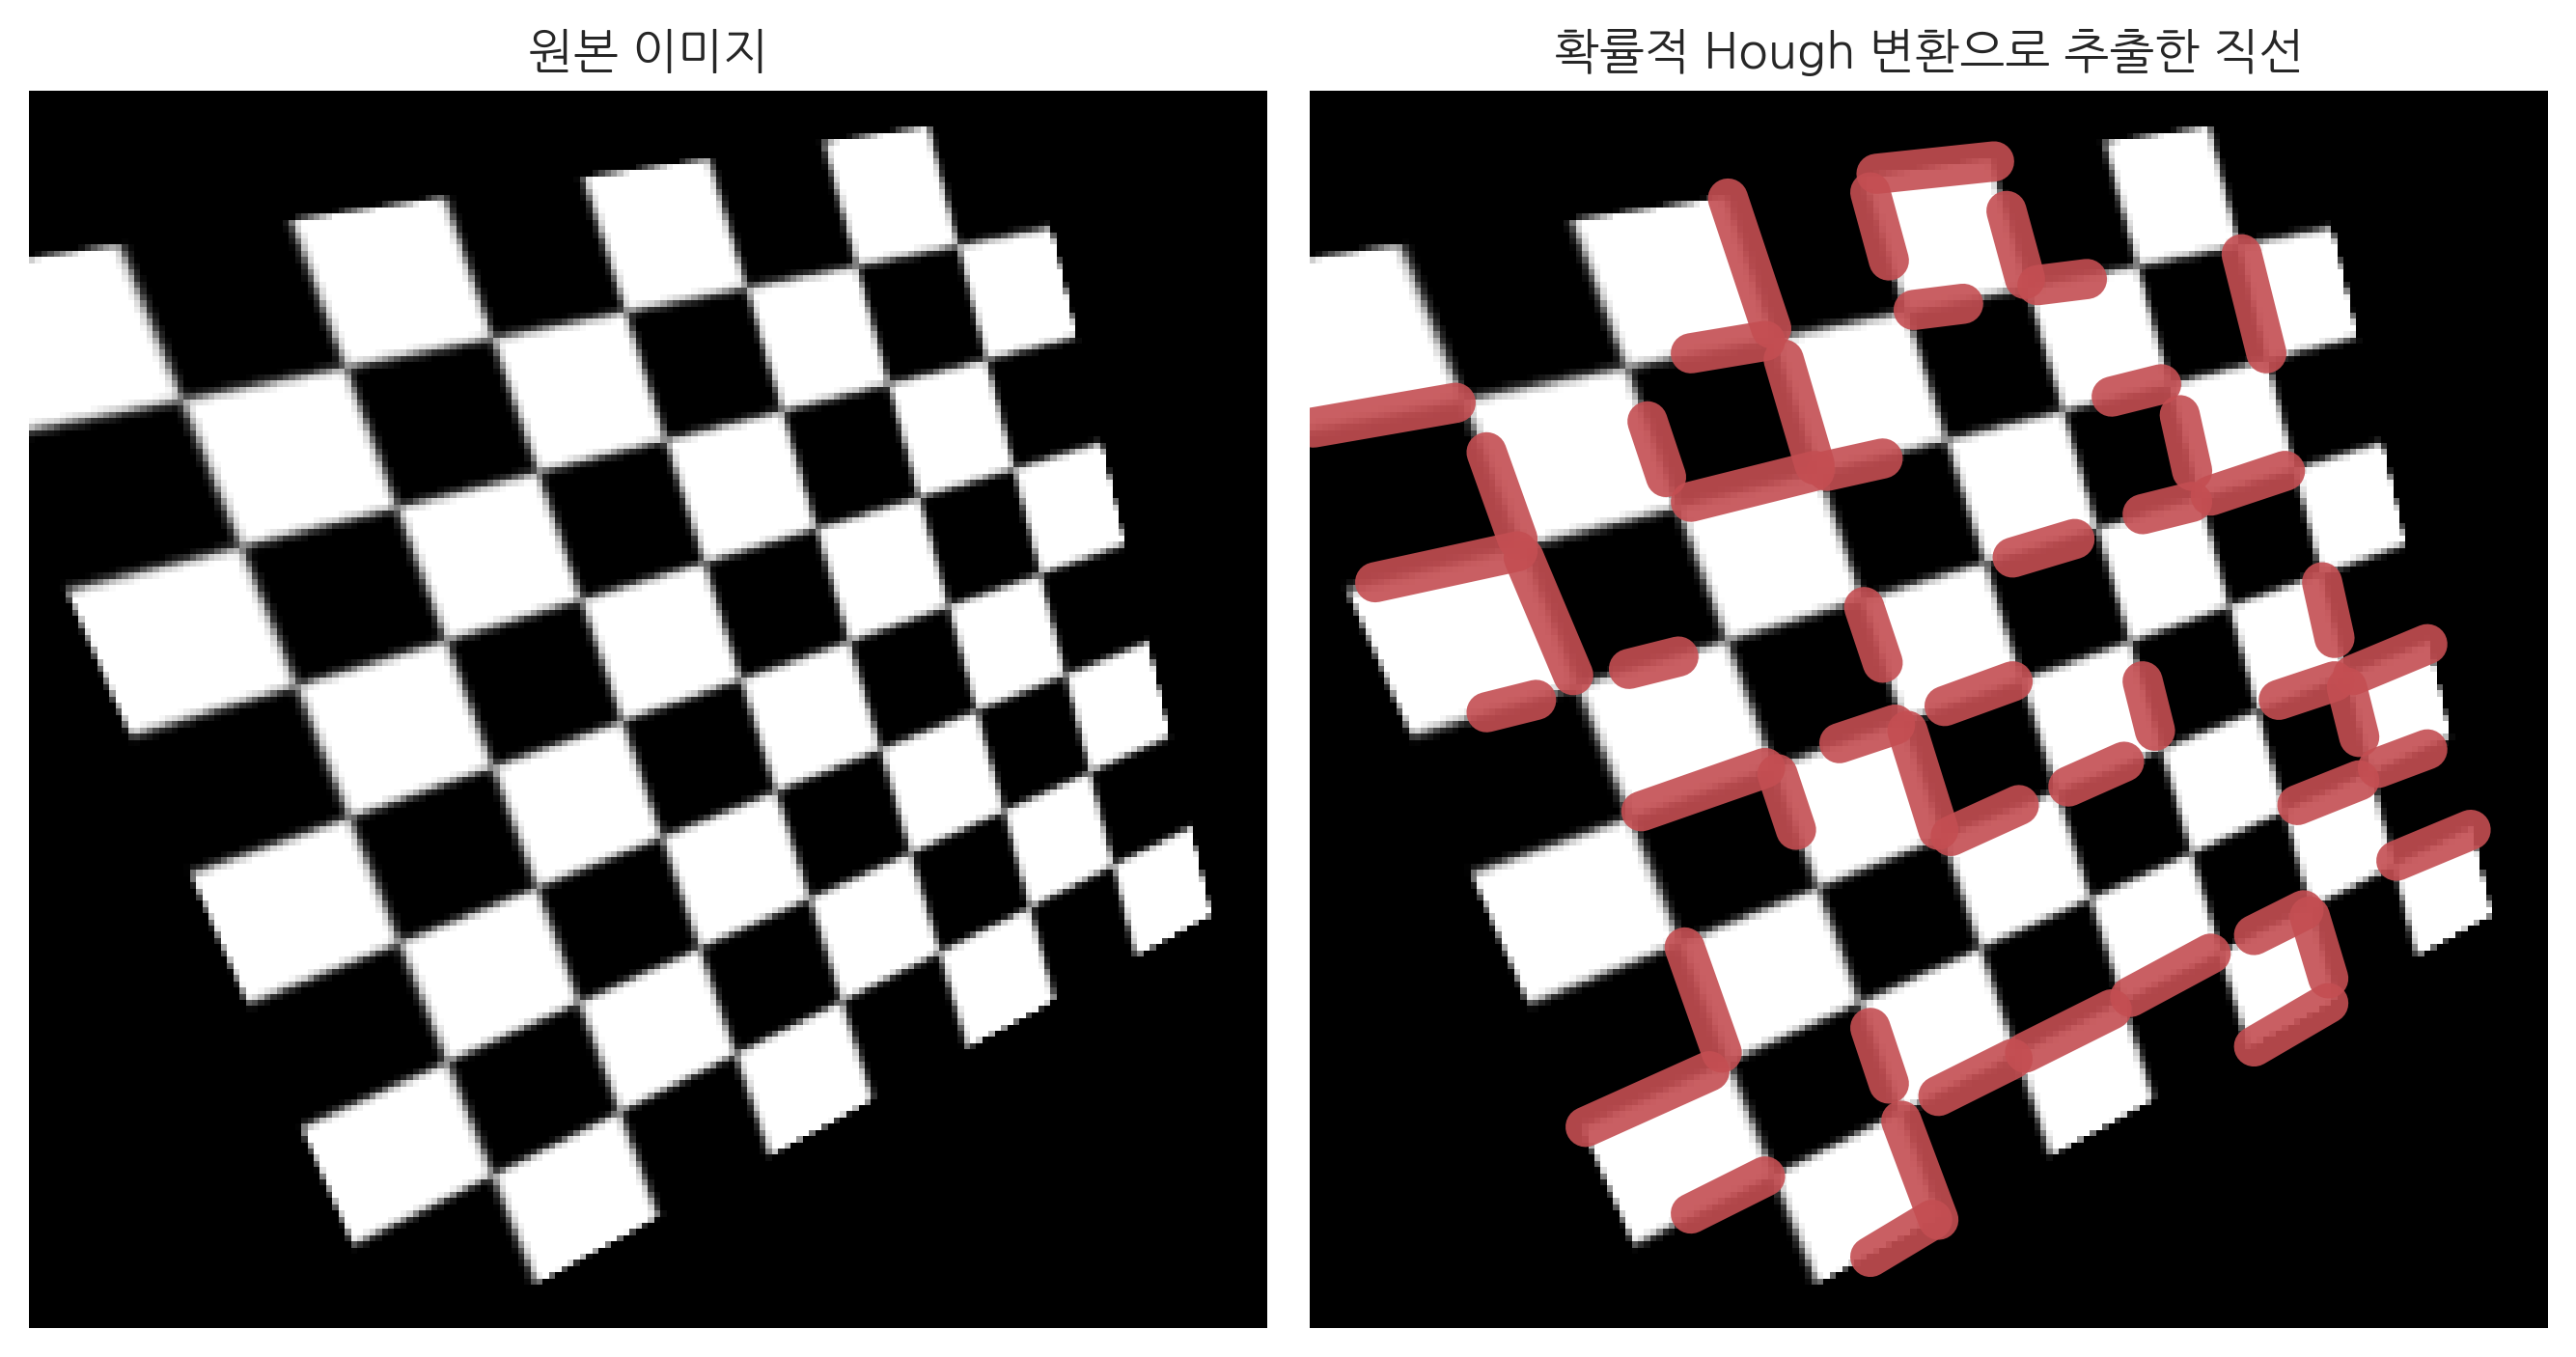

In [5]:
from skimage.data import checkerboard

img = checkerboard()
rows, cols = img.shape

pts1 = np.float32([[25, 25], [175, 25], [25, 175], [175, 175]])
pts2 = np.float32([[25, 50], [150, 25], [75, 175], [175, 125]])

H = cv2.getPerspectiveTransform(pts1, pts2)
img = cv2.warpPerspective(img, H, (cols, rows))

edges = cv2.Canny(img, 100, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, 50, 8)

plt.figure(figsize=(9, 7))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("원본 이미지")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis("off")
for i in range(len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        plt.plot([x1, x2], [y1, y2], c='r', lw=10, alpha=0.9)
plt.title("확률적 Hough 변환으로 추출한 직선")

plt.tight_layout()
plt.show()

## 이미지 히스토그램

데이터 집합에서 특정 구간의 값을 가지는 데이터의 갯수를 세어 나타낸 것이 히스토그램이다. 이미지 히스토그램은 이미지에서 특정 밝기 구간에 들어가는 픽셀의 수를 나타낸 것이다.

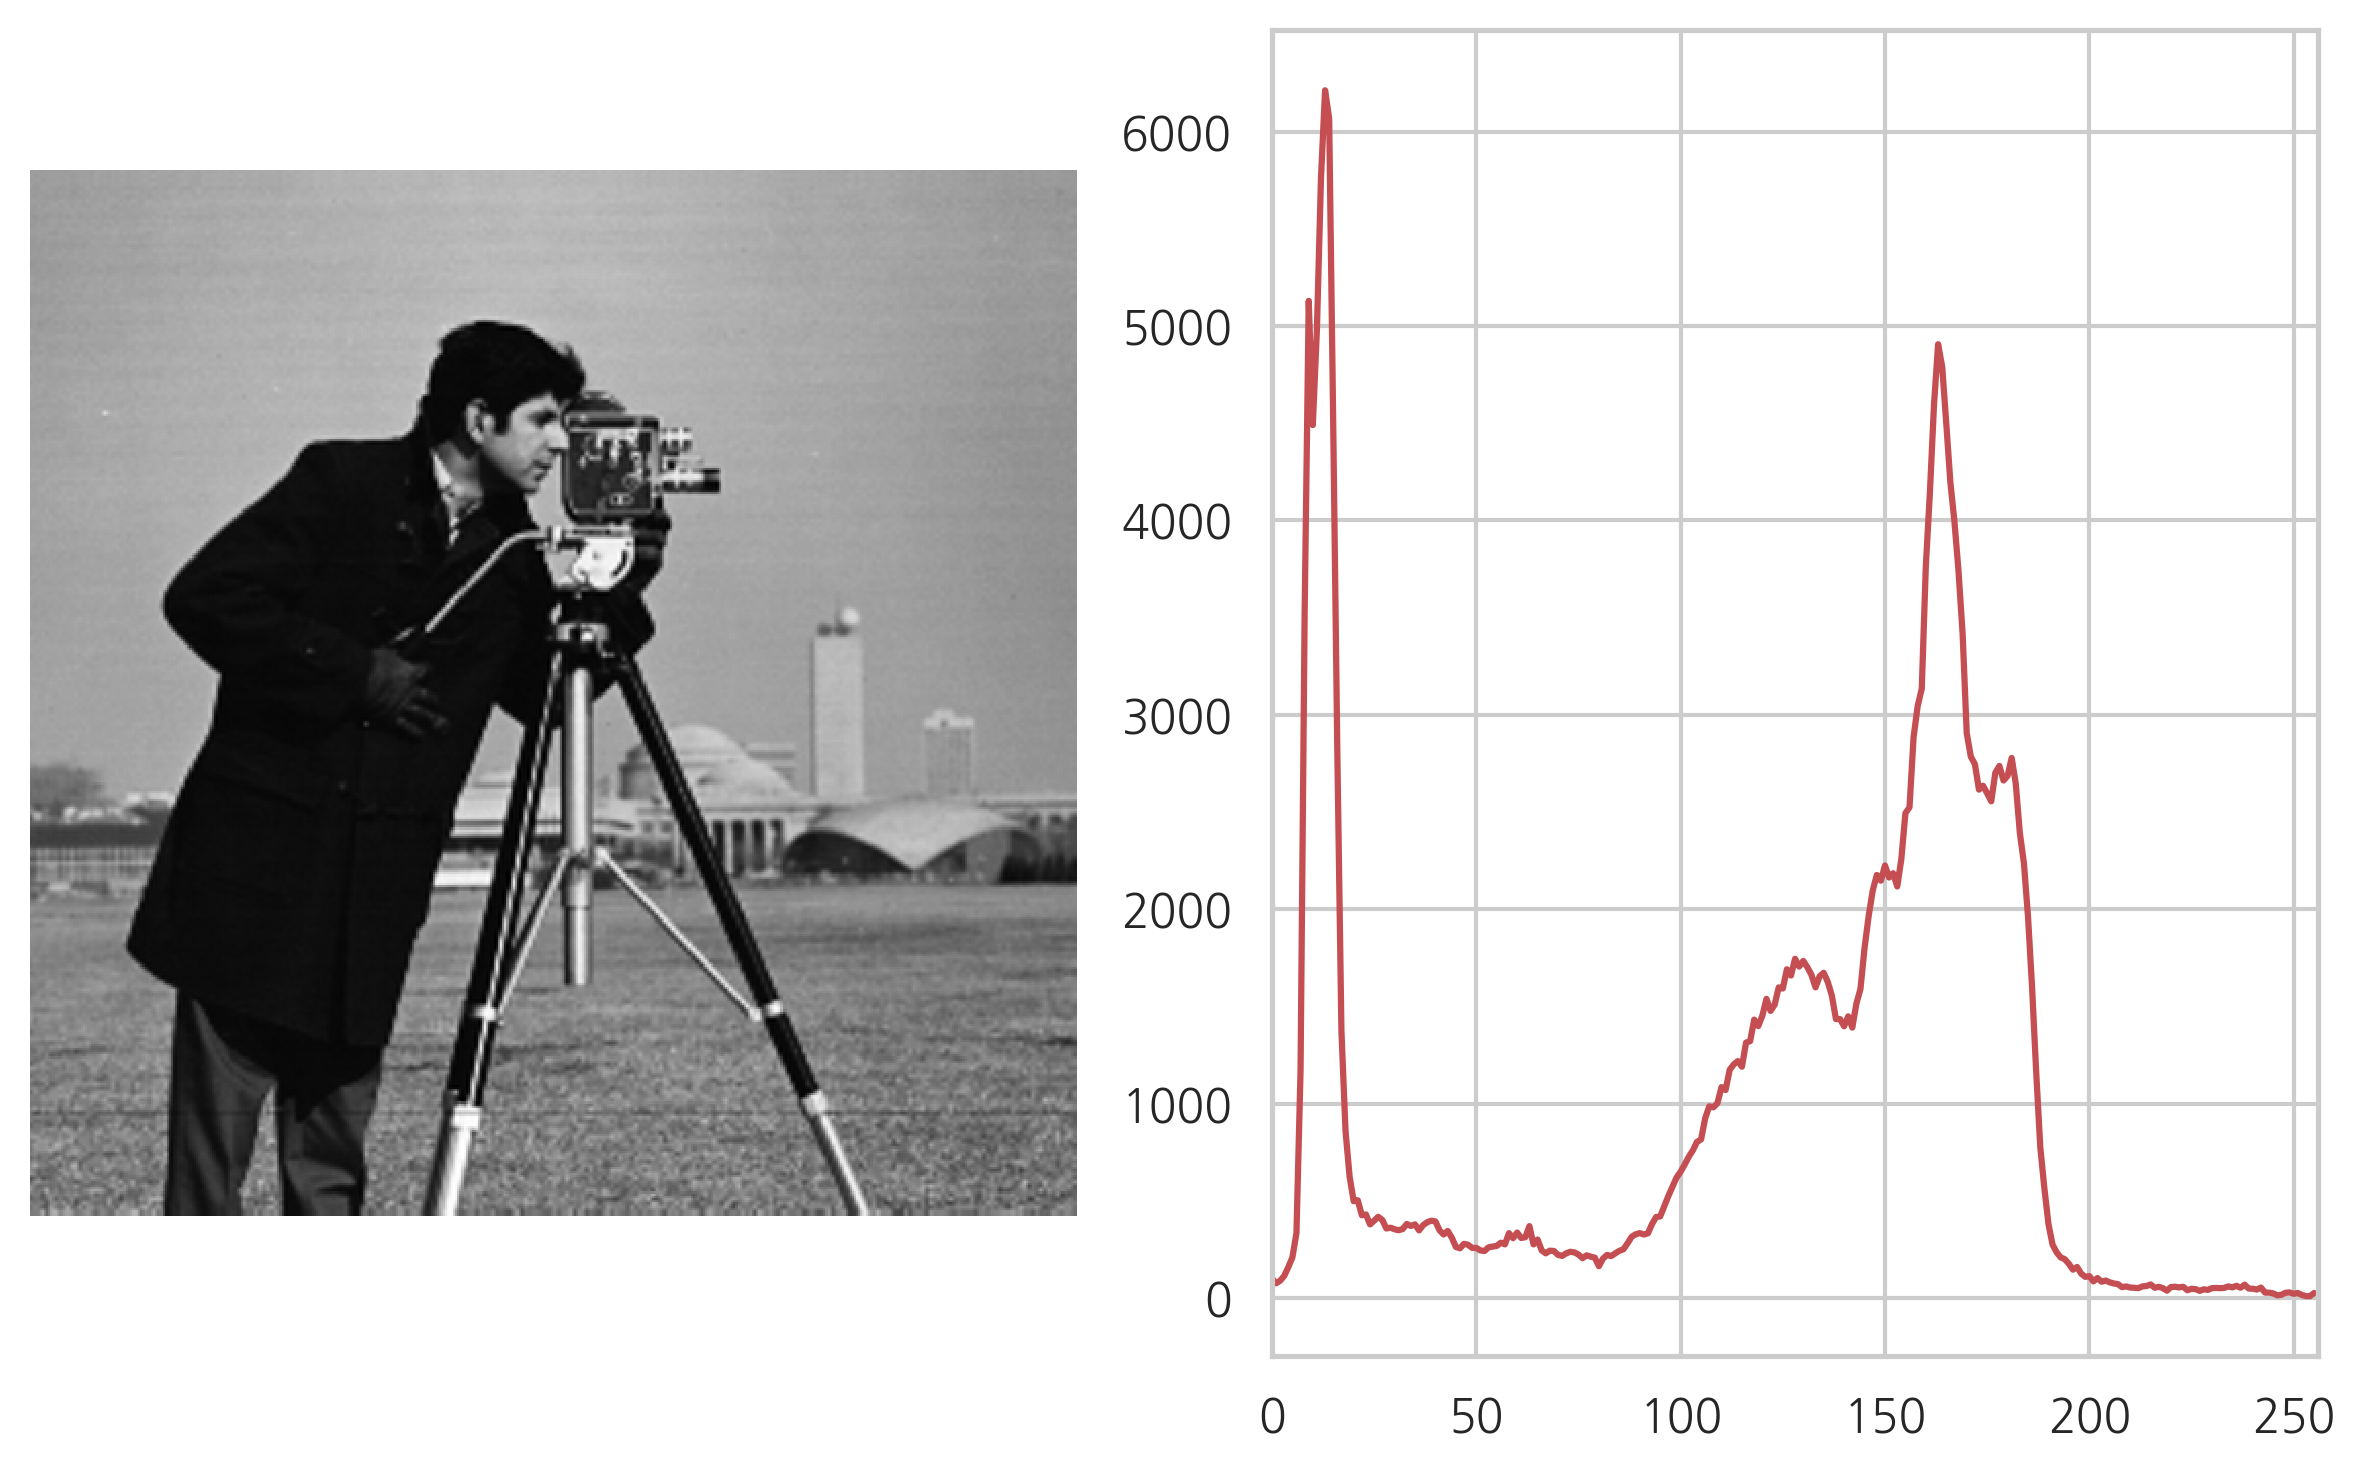

In [6]:
from skimage.data import camera
img = camera()

hist = cv2.calcHist([img], [0], None, [256], [0, 256])

plt.subplot(121)
plt.imshow(img, "gray")
plt.axis("off")
plt.subplot(122)
plt.plot(hist, color='r')
plt.xlim([0, 256])
plt.tight_layout()
plt.show()

## 그레디언트 히스토그램 설명자

특징점의 주변 특성을 이용해 해당 특징점을 표현하는 벡터를 만들어 이미지에서 같은 특징점을 매칭하거나 추출 할 때 사용한다. 이를 **설명자(descriptor)**라고 한다. 방법은 다음과 같다.

1. 특징점을 중심으로 16x16 영역을 4x4 크기의 16개 윈도우로 나눈다.
2. 윈도우의 16개 포인트에서 그레디언트 벡터의 크기와 방향을 계산한다.
3. 그레디언트 벡터의 방향을 8개의 각도로 라운딩(rouding)한다.
4. 8개의 각도에 대해 그레디언트 벡터의 크기를 더하여 일종의 그레디언트 히스토그램을 만든다.
5. 윈도우 16개의 히스토그램을 모두 모으면, 특징점 주변에 대한 정보가 128(8 x 16)차원의 벡터로 표현된다. 

<img src="https://datascienceschool.net/upfiles/b50a6467241344ae8f857b63cbd6d2de.png" width="100%">

그림 38.4 : SIFT의 설명자

## SIFT

SIFT(Scale-Invariant Feature Transform)은 특징점의 크기와 각도까지 같이 계산하여 이미지의 크기가 변하거나 회전해도 동일한 특징점을 찾을 수 있도록 하는 방법이다. 또한 특징점 근처의 이미지 특성(히스토그램)도 같이 계산해서 특징점 이미지의 모양도 구별할 수 있도록 한다.

1. 먼저 **크기**에 불변한 특징점을 추출하기 위해서, 스케일 피라미드(Scale-Pyrimid)를 만든다. 스케일 피라미드란 이미지의 원본 이미지에서 2배, 1배, 1/2배, 1/4배 점차 줄인 이미지이다.
2. 이렇게 만든 스케일 피라미드의 각 이미지에서 특징점을 찾는다. 이렇게 찿은 특징점은 스케일 불변(Scale-Invariant)이다. 하지만 이미지의 회전에는 불변이 아니다. 
4. 회전 불변 특성을 위해 특징점 주변의 그레디언트 방향과 크기를 수집한다. 특징점을 중심으로 윈도우를 설정하여 그 안의 픽셀에 대한 그레디언트의 크기와 방향을 구한다. 
5. 360도를 36등분하여 36개의 bin을 가진 그레디언트 벡터 히스토그램을 만든다. 가장 값이 큰 bin이 해당 특징점의 방향, 그 bin의 크기가 특징점의 크기가 된다.


다음 코드는 이미지에 대해 `SIFT` 특징을 찾고, 변환된 이미지에서 같은 특징점 끼리 매칭하는 작업을 수행한다. 

In [7]:
from skimage.data import camera
img = camera()

rows, cols = img.shape
H = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 0.7)
img_rotated = cv2.warpAffine(img, H, (cols, rows))
sift = cv2.xfeatures2d.SIFT_create()
kps, des = sift.detectAndCompute(img, None)
kps_r, des_r = sift.detectAndCompute(img_rotated, None)
kp0 = kps[0]
print("pt=({},{}), size={}, angle={}".format(kp0.pt[0], kp0.pt[1], kp0.size, kp0.angle))

pt=(2.347715139389038,486.962890625), size=2.006916046142578, angle=234.960693359375


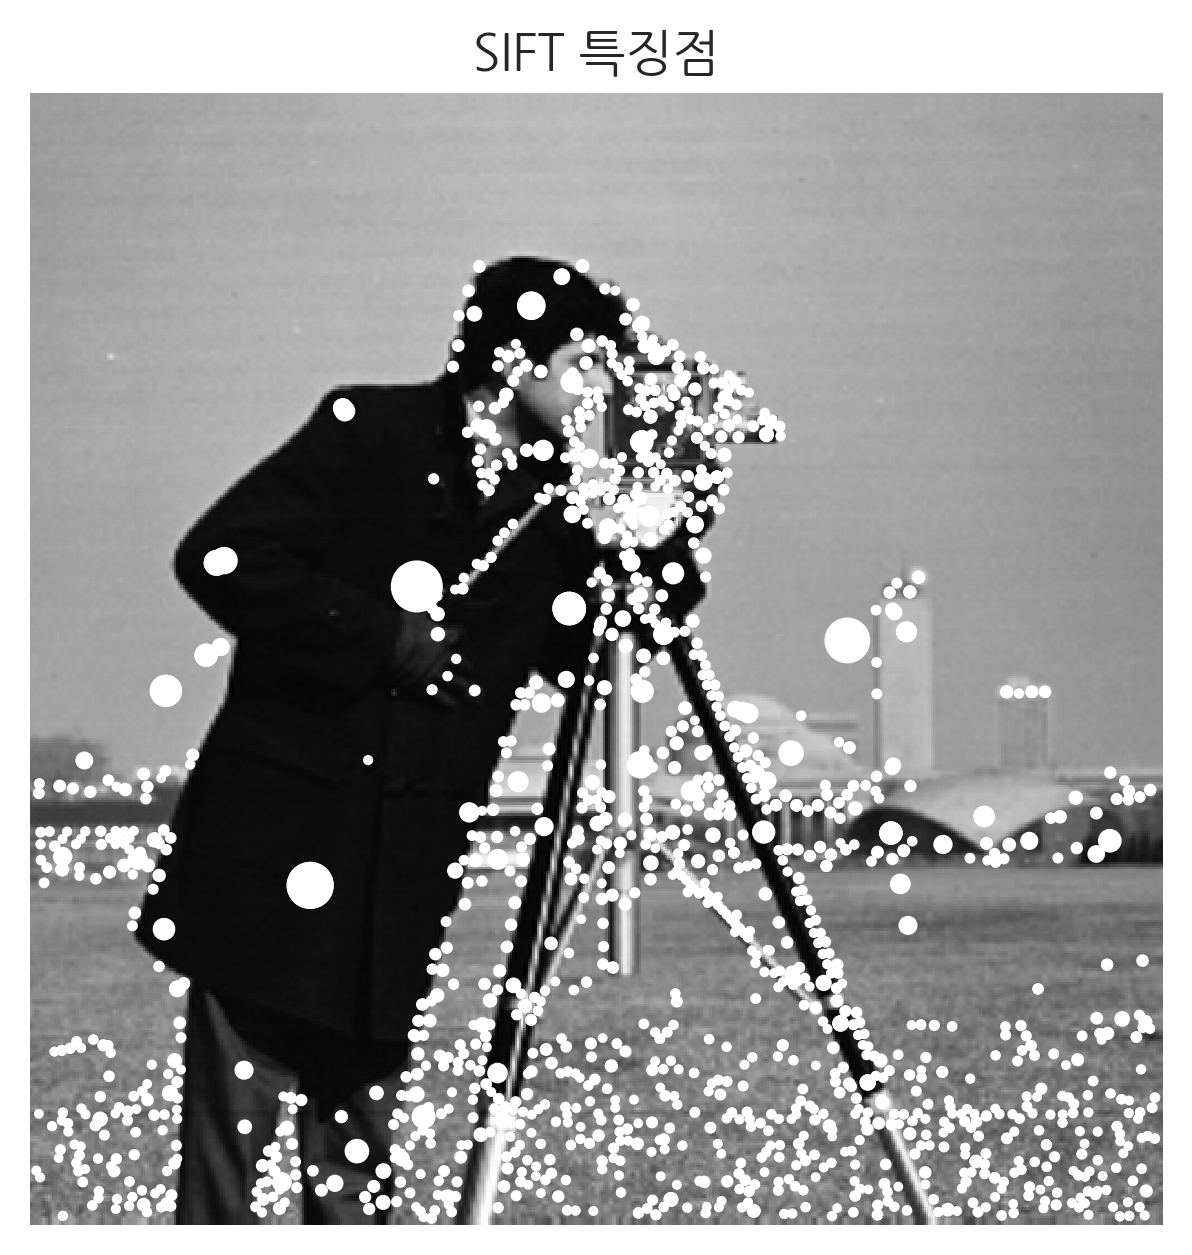

In [8]:
bf = cv2.BFMatcher_create()
matches = bf.knnMatch(des, des_r, k=2)

good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

np.random.shuffle(good)
image_match = cv2.drawMatchesKnn(
    img, kps, img_rotated, kps_r, good[:10], flags=2, outImg=img)

pts_x = [kp.pt[0] for kp in kps]
pts_y = [kp.pt[1] for kp in kps]
pts_s = [kp.size for kp in kps]

plt.imshow(img, cmap="gray")
plt.title("SIFT 특징점")
plt.axis("off")
plt.scatter(pts_x, pts_y, s=pts_s, c="w")
plt.show()

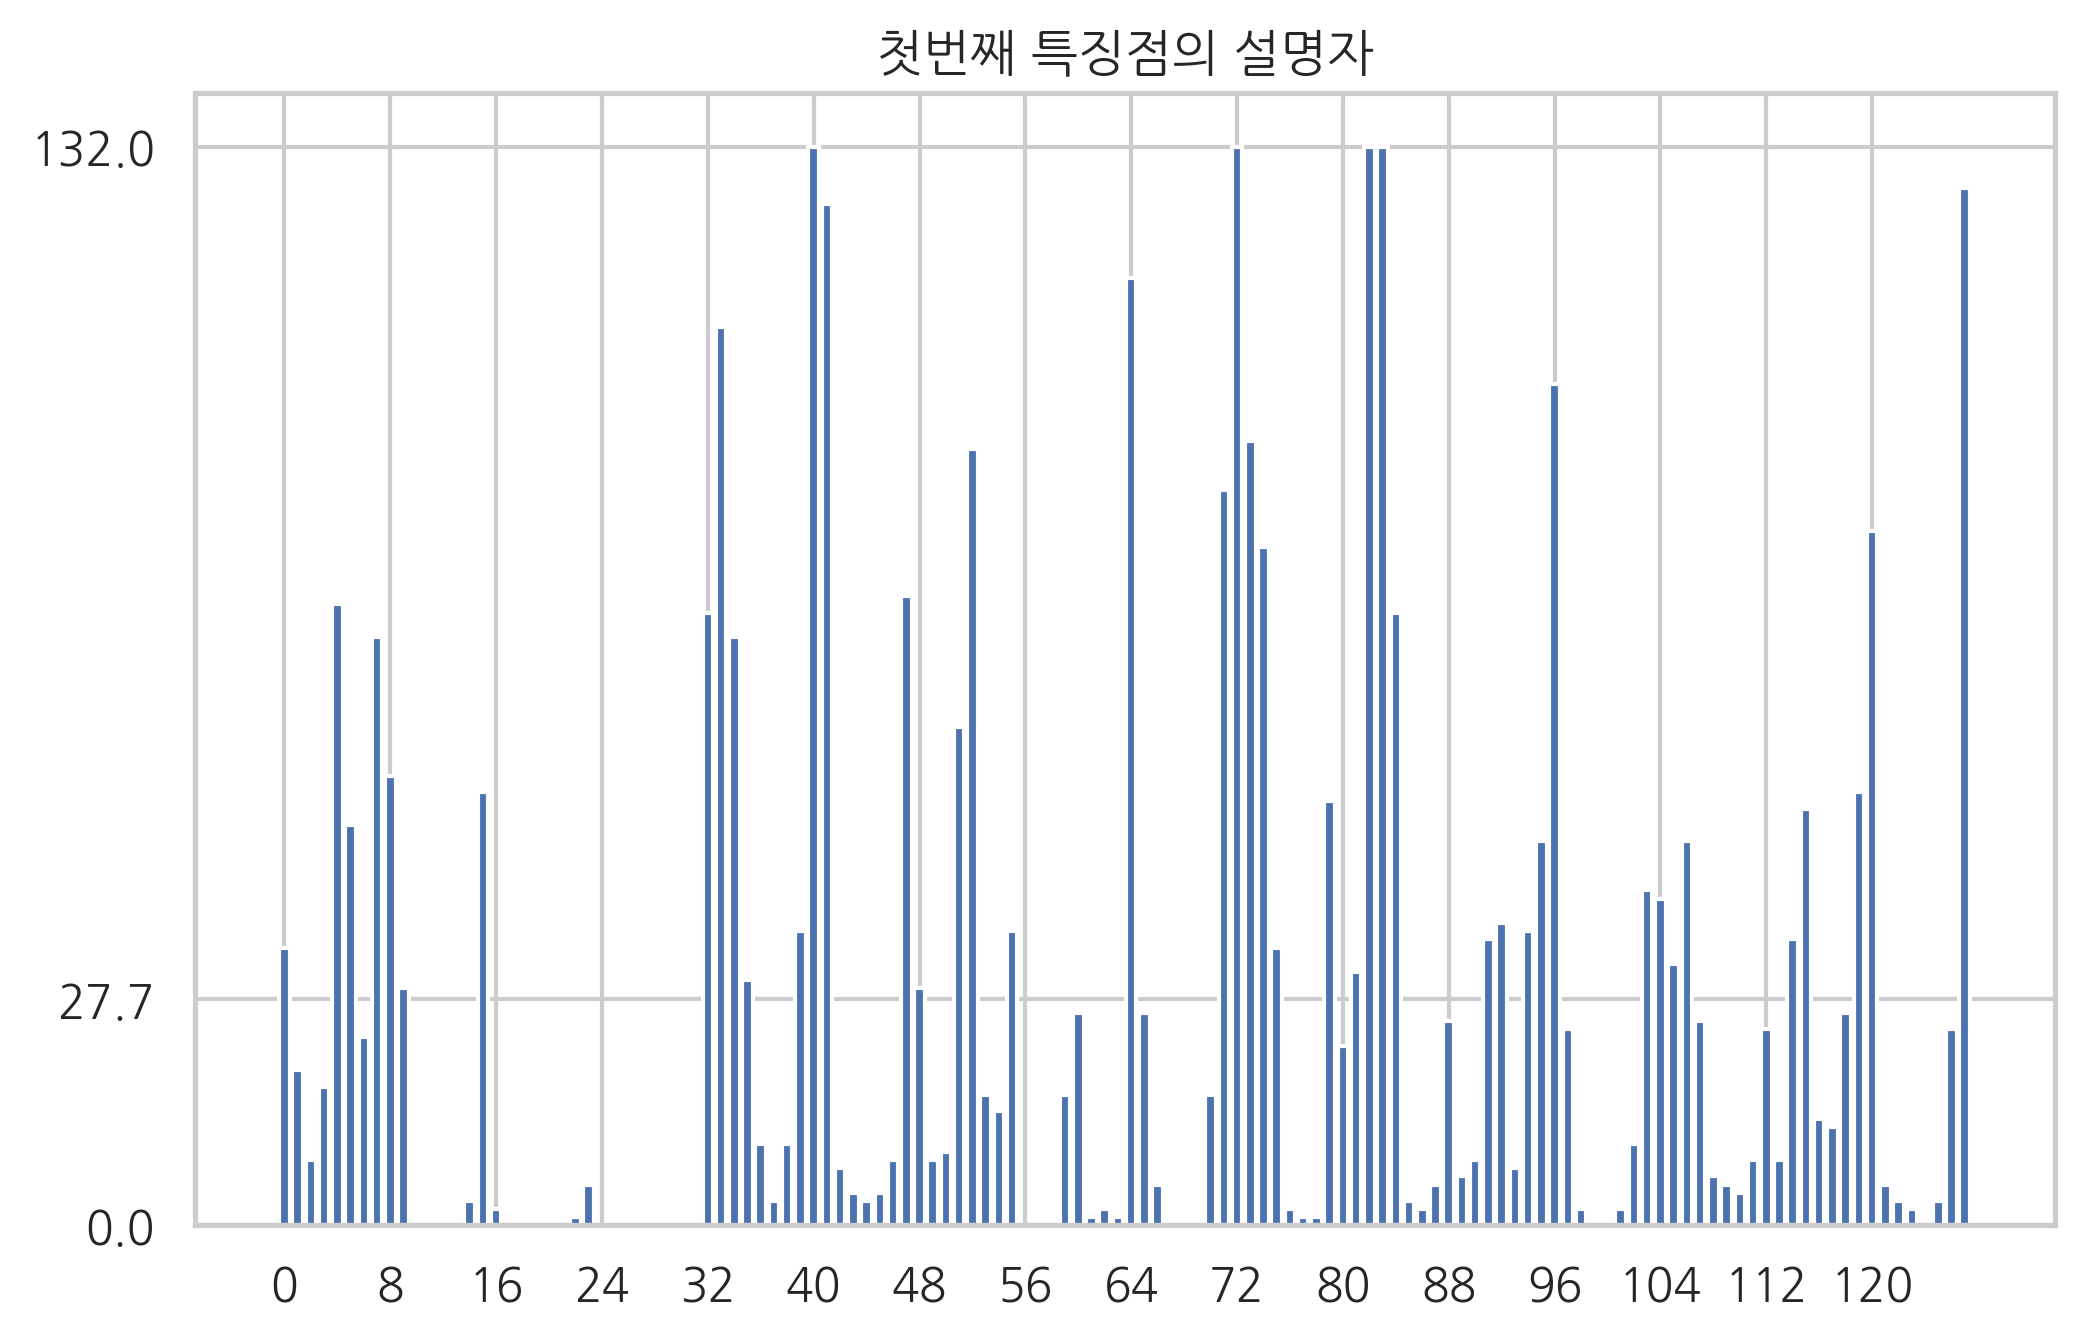

In [9]:
plt.bar(np.arange(len(des[0])), des[0])
plt.xticks(range(0, len(des[0]), 8))
plt.yticks([des[0].min(), des[0].mean(), des[0].max()])
plt.title("첫번째 특징점의 설명자")
plt.show()

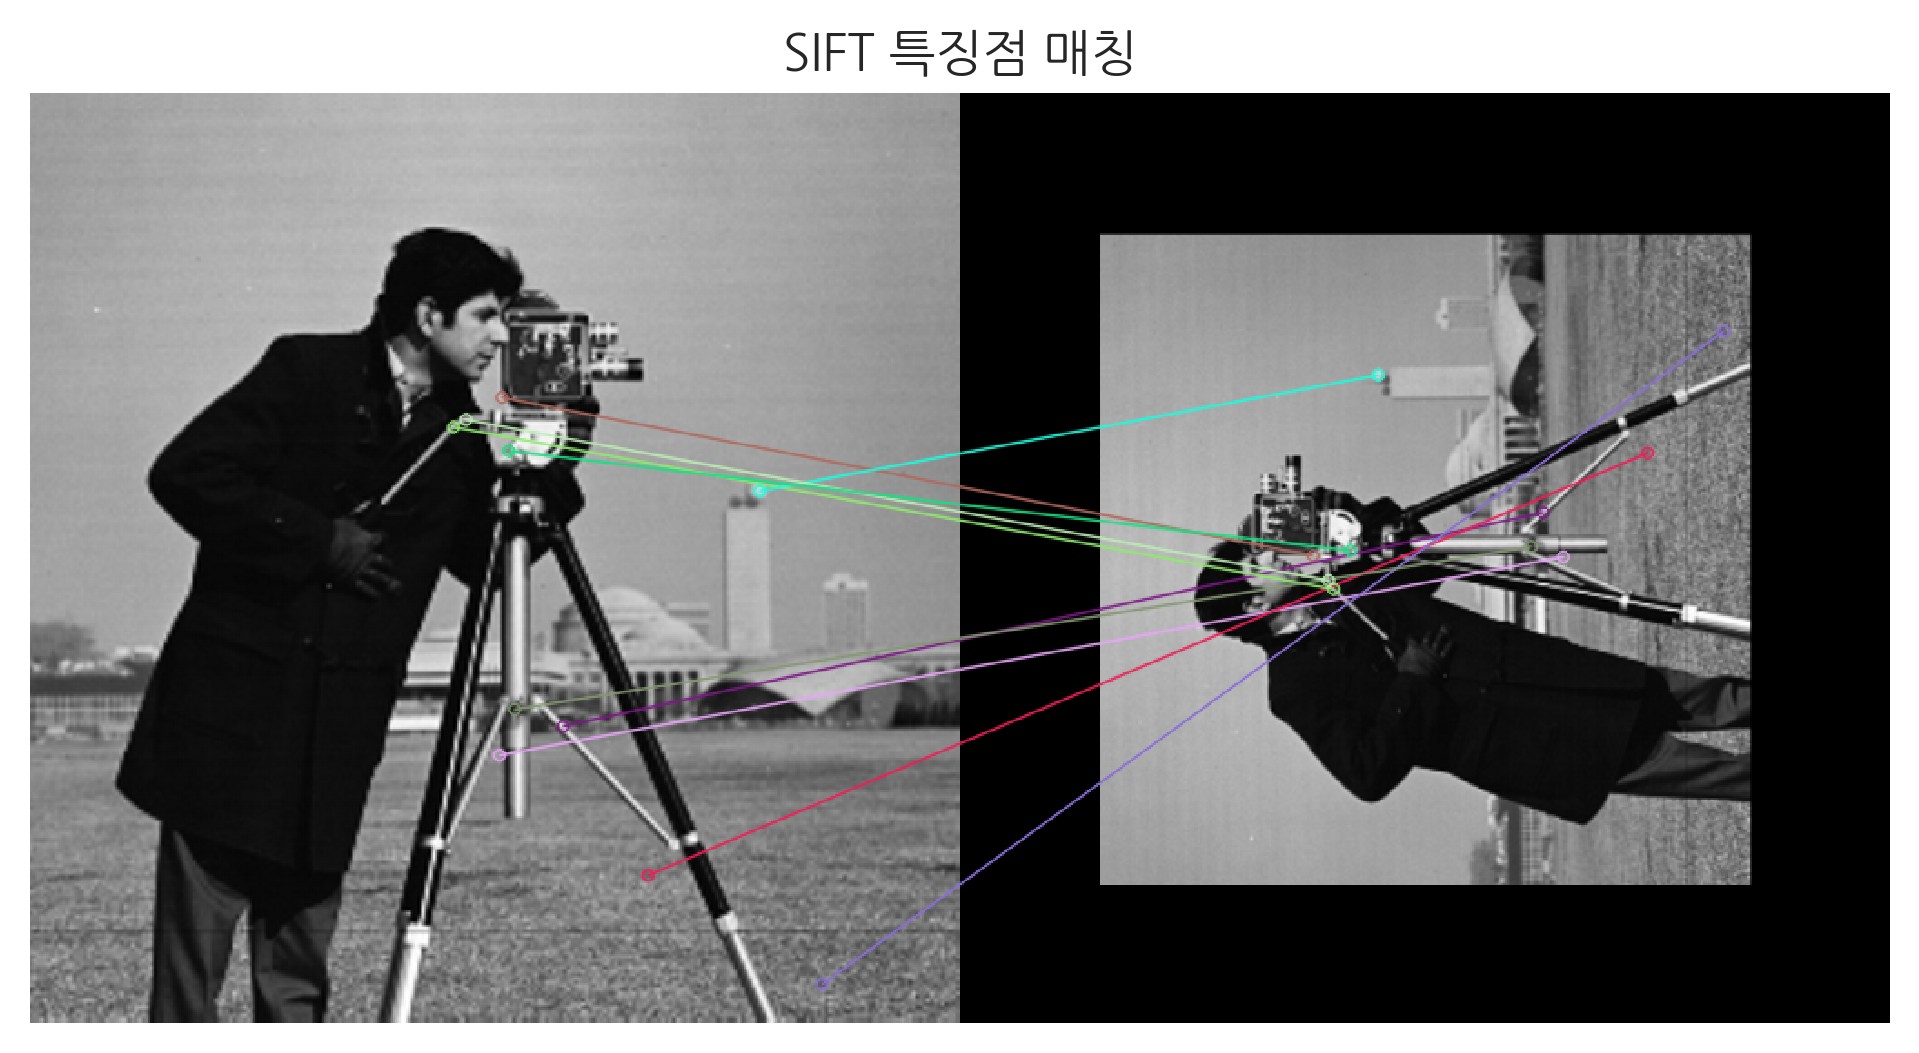

In [10]:
plt.imshow(image_match)
plt.title("SIFT 특징점 매칭")
plt.axis("off")
plt.show()

## SURF

SURF(Speeded-Up Robust Features)는 인텐서티 계산 방법을 간략화 하는 등의 방법으로 SIFT 방법의 속도와 안정성을 개선한 것이다. 다음 코드는 이미지에 대해 `SURF` 특징을 찾고, 변환된 이미지에서 같은 특징점 끼리 매칭하는 작업을 수행한다. 

In [11]:
surf = cv2.xfeatures2d.SURF_create(400)
kps, des = surf.detectAndCompute(img, None)
kps_r, des_r = surf.detectAndCompute(img_rotated, None)

kp0 = kps[0]
print("pt=({},{}), size={}, angle={}".format(kp0.pt[0], kp0.pt[0], kp0.size, kp0.angle))

pt=(222.9388885498047,222.9388885498047), size=17.0, angle=343.84210205078125


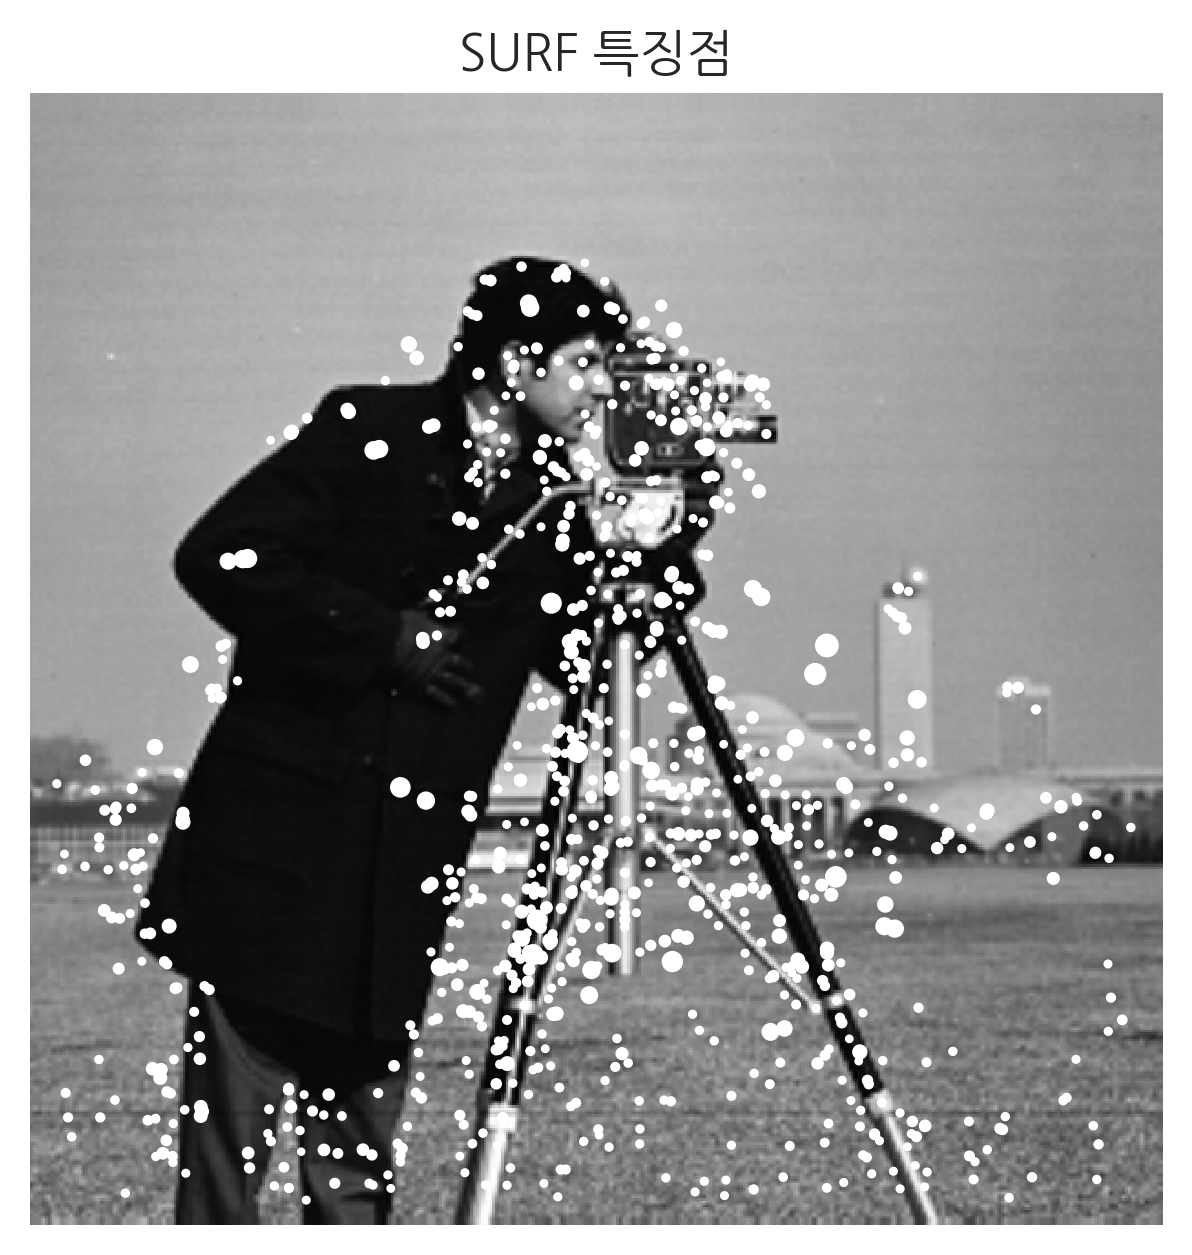

In [12]:
bf = cv2.BFMatcher_create()
matches = bf.knnMatch(des, des_r, k=2)

good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

np.random.shuffle(good)
image_match = cv2.drawMatchesKnn(
    img, kps, img_rotated, kps_r, good[:10], flags=2, outImg=img)

pts_x = [kp.pt[0] for kp in kps]
pts_y = [kp.pt[1] for kp in kps]
pts_s = [kp.size / 10 for kp in kps]

plt.imshow(img, cmap='gray')
plt.title("SURF 특징점")
plt.axis("off")
plt.scatter(pts_x, pts_y, s=pts_s, c="w")
plt.show()

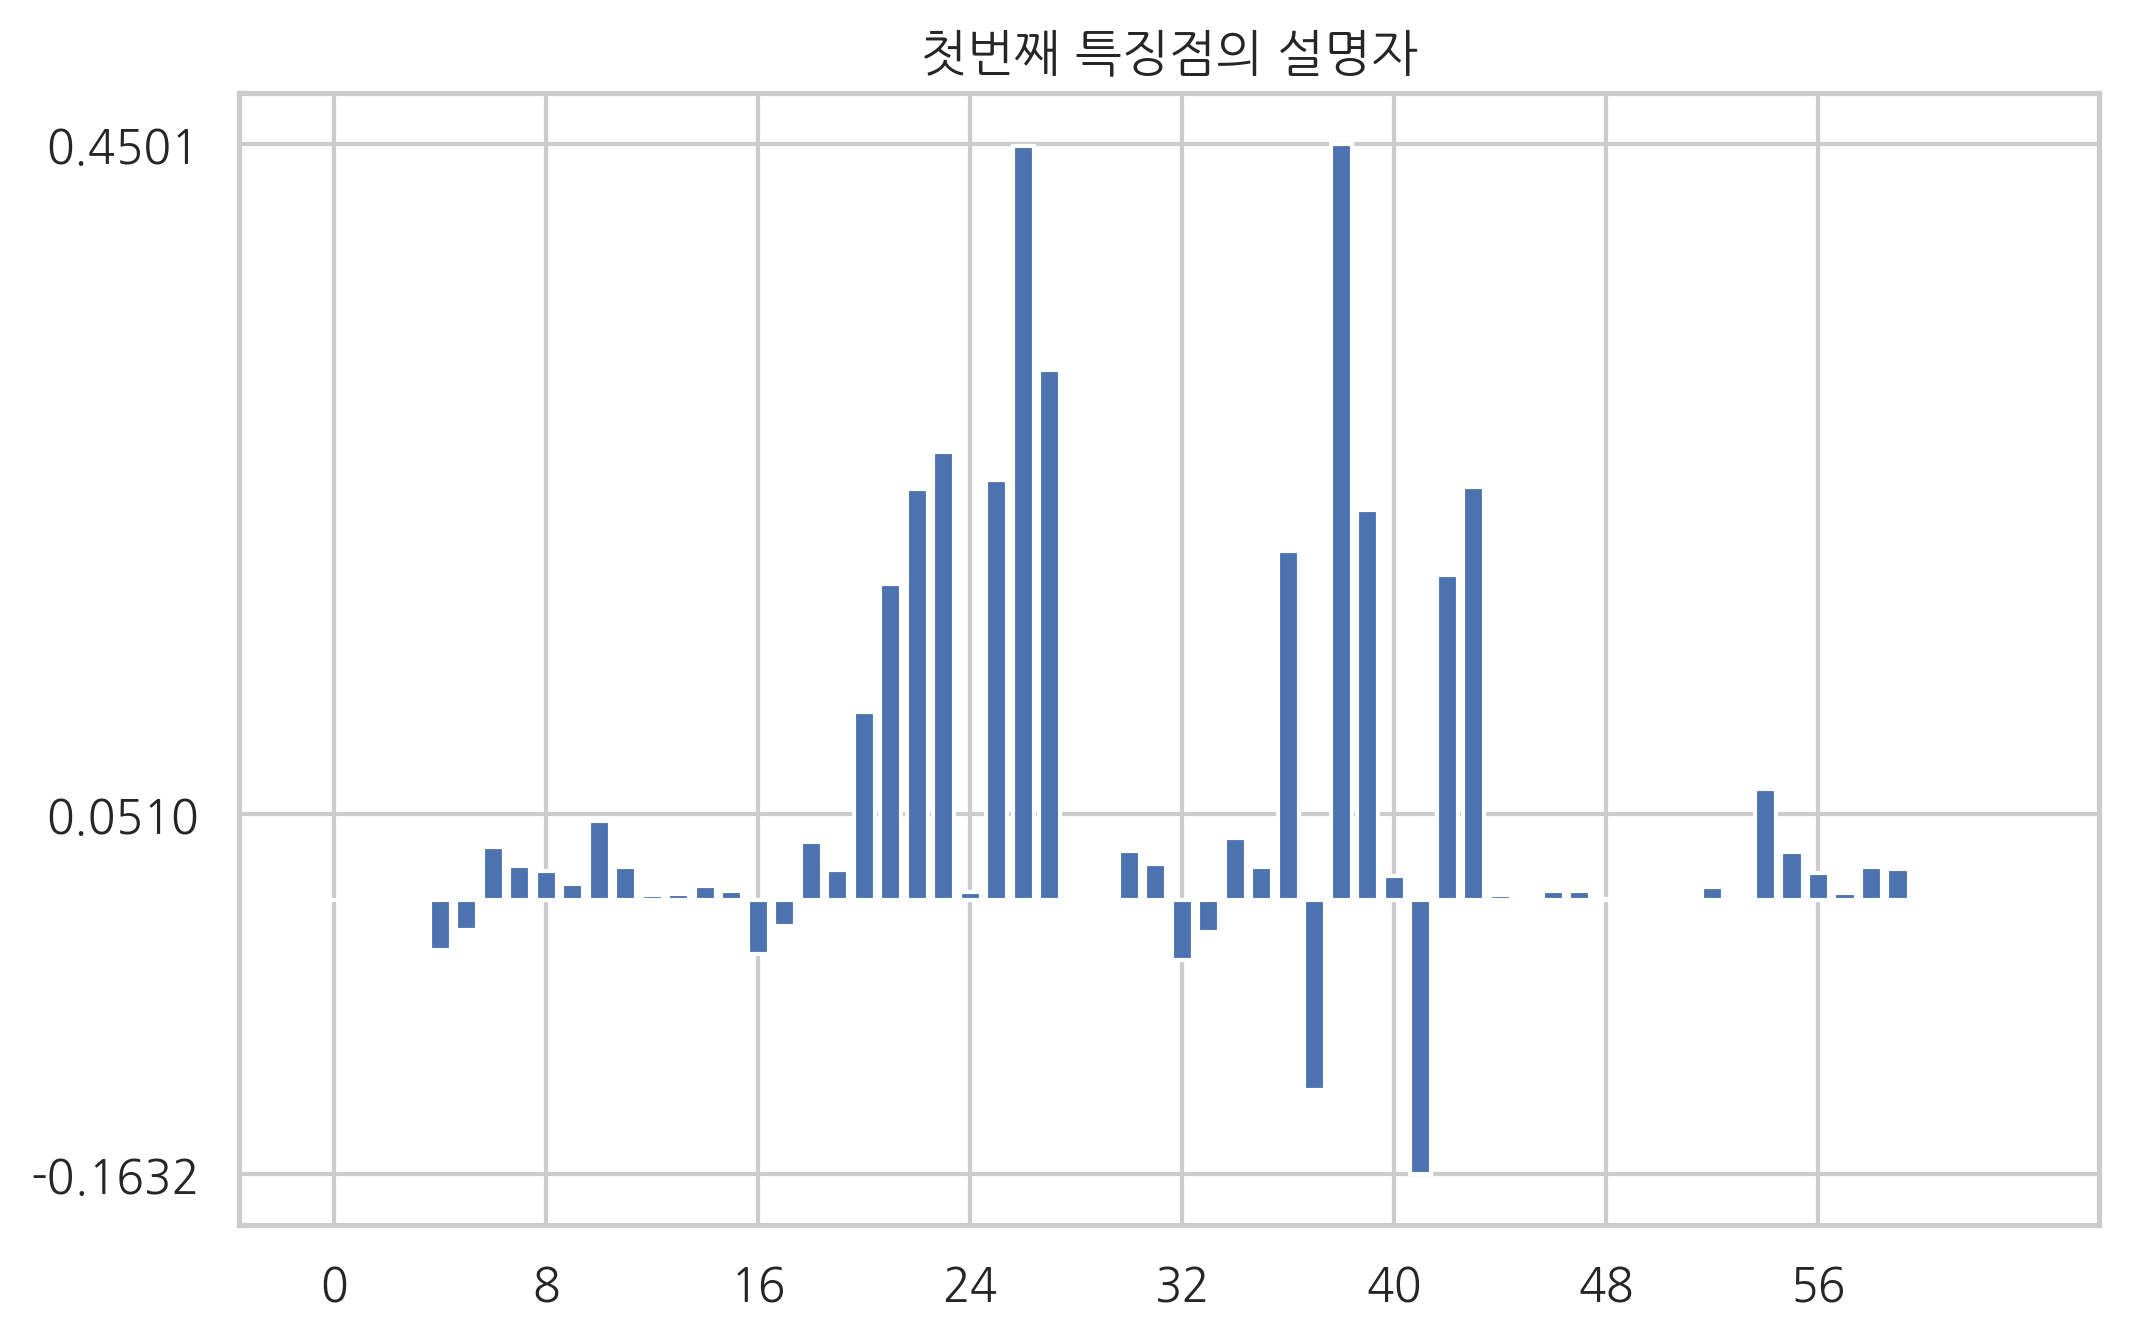

In [13]:
plt.bar(np.arange(len(des[0])), des[0])
plt.xticks(range(0, len(des[0]), 8))
plt.yticks([des[0].min(), des[0].mean(), des[0].max()])
plt.title("첫번째 특징점의 설명자")
plt.show()

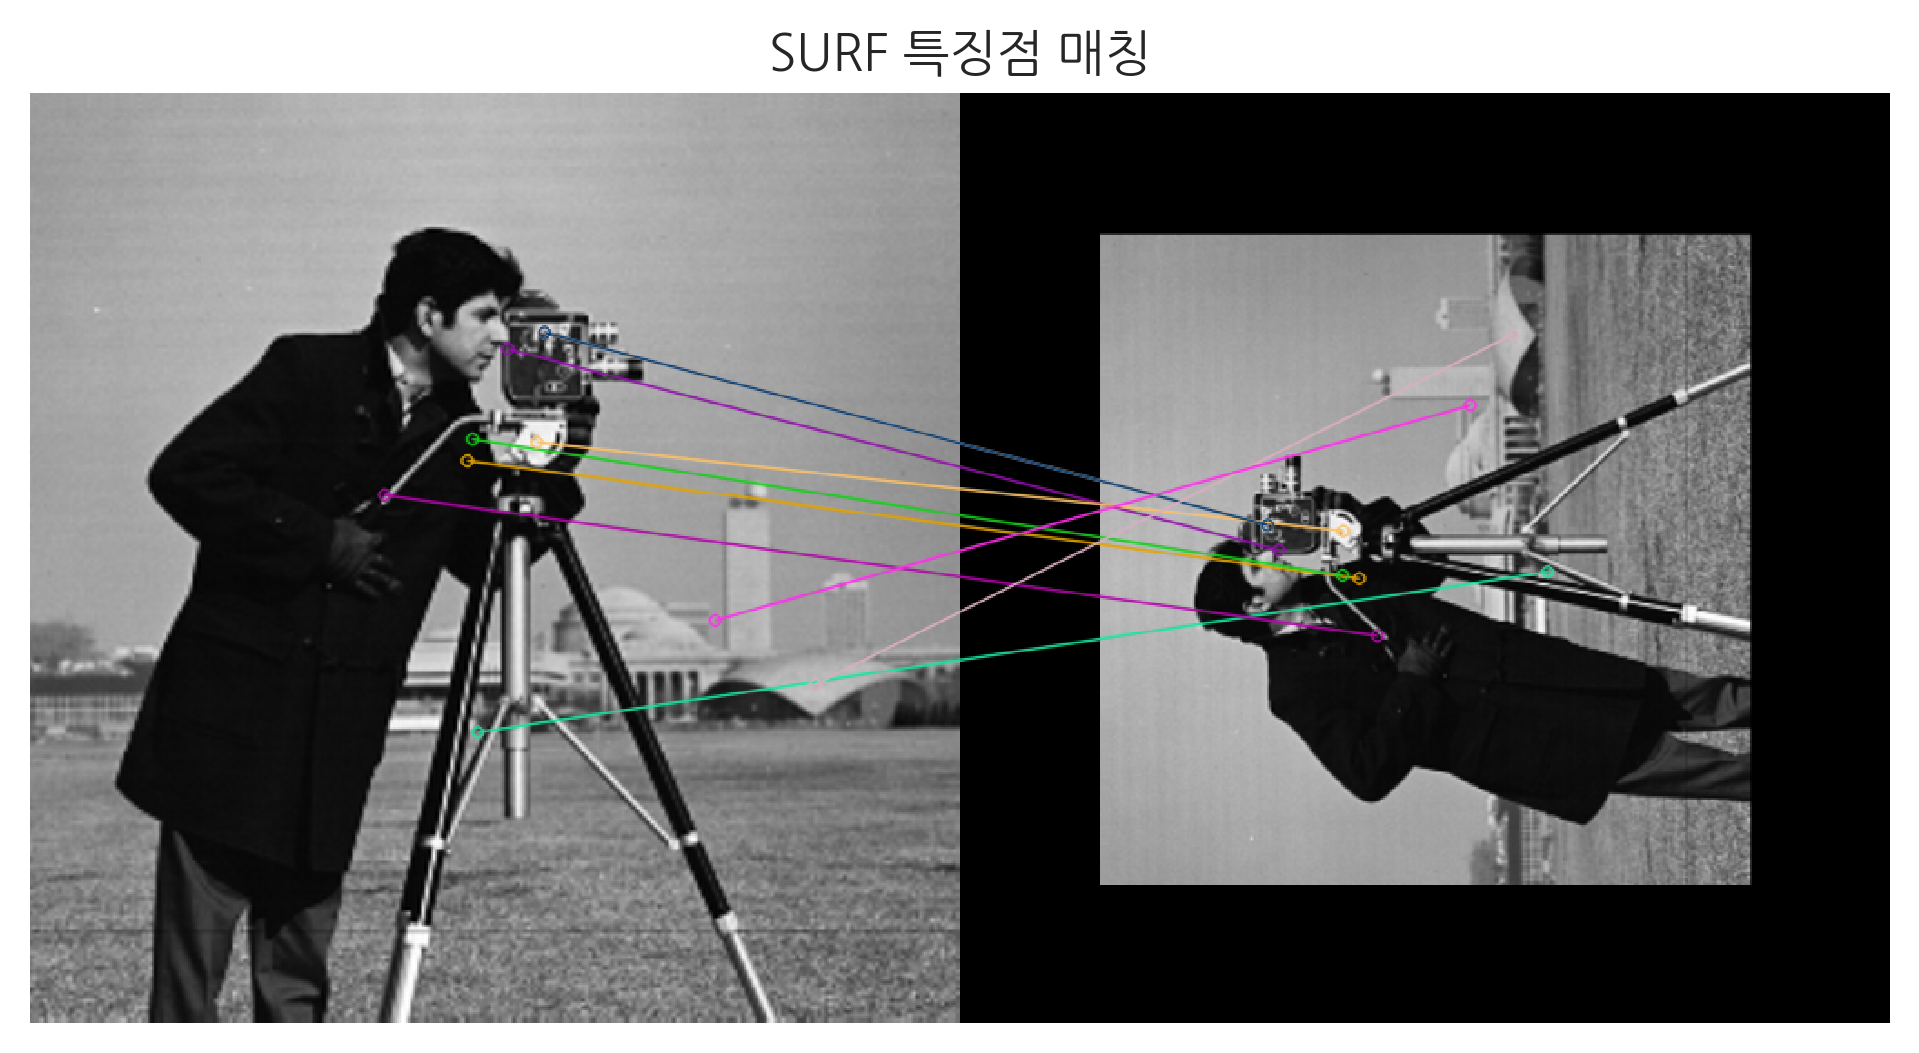

In [14]:
plt.imshow(image_match)
plt.title("SURF 특징점 매칭")
plt.axis("off")
plt.show()

## FAST

FAST(Features from Accelerated Segment Test)도 코너를 찾는 알고리즘이다. 이름처럼 빠른 연산으로 유명하다. 
 
1. 한 픽셀 $p$ 를 중심으로하는 3픽셀의 반지름을 가지는 원을 만들고, 
2. 그 원 위의 16개의 픽셀 값을 보고 코너를 찾는다. 
3. $p$보다 기준값 이상 밝거나, 어두운 픽셀들이 $n$개 이상 연속적으로 존재하면 $p$를 Corner로 판단한다. 
 
$n$에 따라 FAST-9, FAST-10, FAST-11, FAST-12 등의 여러 버전이 가능하지만, FAST 논문에서는 FAST-9의 성능이 가장 좋다고 한다. 하지만, 이렇게 개수를 세는 방식은 너무 많은 픽셀을 코너라고 판단했고, 16개의 픽셀의 순서를 어떻게 하느냐에 따라서도 추출되는 코너가 바뀔 수 있다는 등등의 이유로 `FAST`에서는 그냥 숫자를 세어 코너를 판단하는 것이 아니라, Decision Tree를 이용해서 코너인가 아닌가를 판단한다. 이때, 16개의 픽셀은 기준값으로 $p$보다 기준값보다 큰, $p$보다 기준값보다 작은, $p$와 유사한 밝기로 바꾸어 16차원의 벡터로 표현하고, 모든 픽셀, 모든 이미지에 대한 벡터를 쌓아 훈련시킨다. 이 때 타겟값은 특징점인지 아닌지인데, 이는 라벨링을 해주어야 한다. 
또하나의 문제점은 한 점이 코너로 판단되면, 주변의 픽셀 또한 코너로 인식되는데, 이는 non-maximal suppression라는 후처리 작업으로 해결했다. 코너성을 대변하는 수치를 계산하고 이를 기준으로 인접 픽셀에 대해 가장 높은 코너성 수치를 가지는 픽셀만 코너로 선택하는 것이다. 

다음 코드는 `FAST`를 사용해 체크보드 이미지의 코너를 찾은 예이다. 

기준값:  10
nonmaxSuppression:  True
nonmaxSuppression 후처리 후, 추출된 전체 특징점:  3351


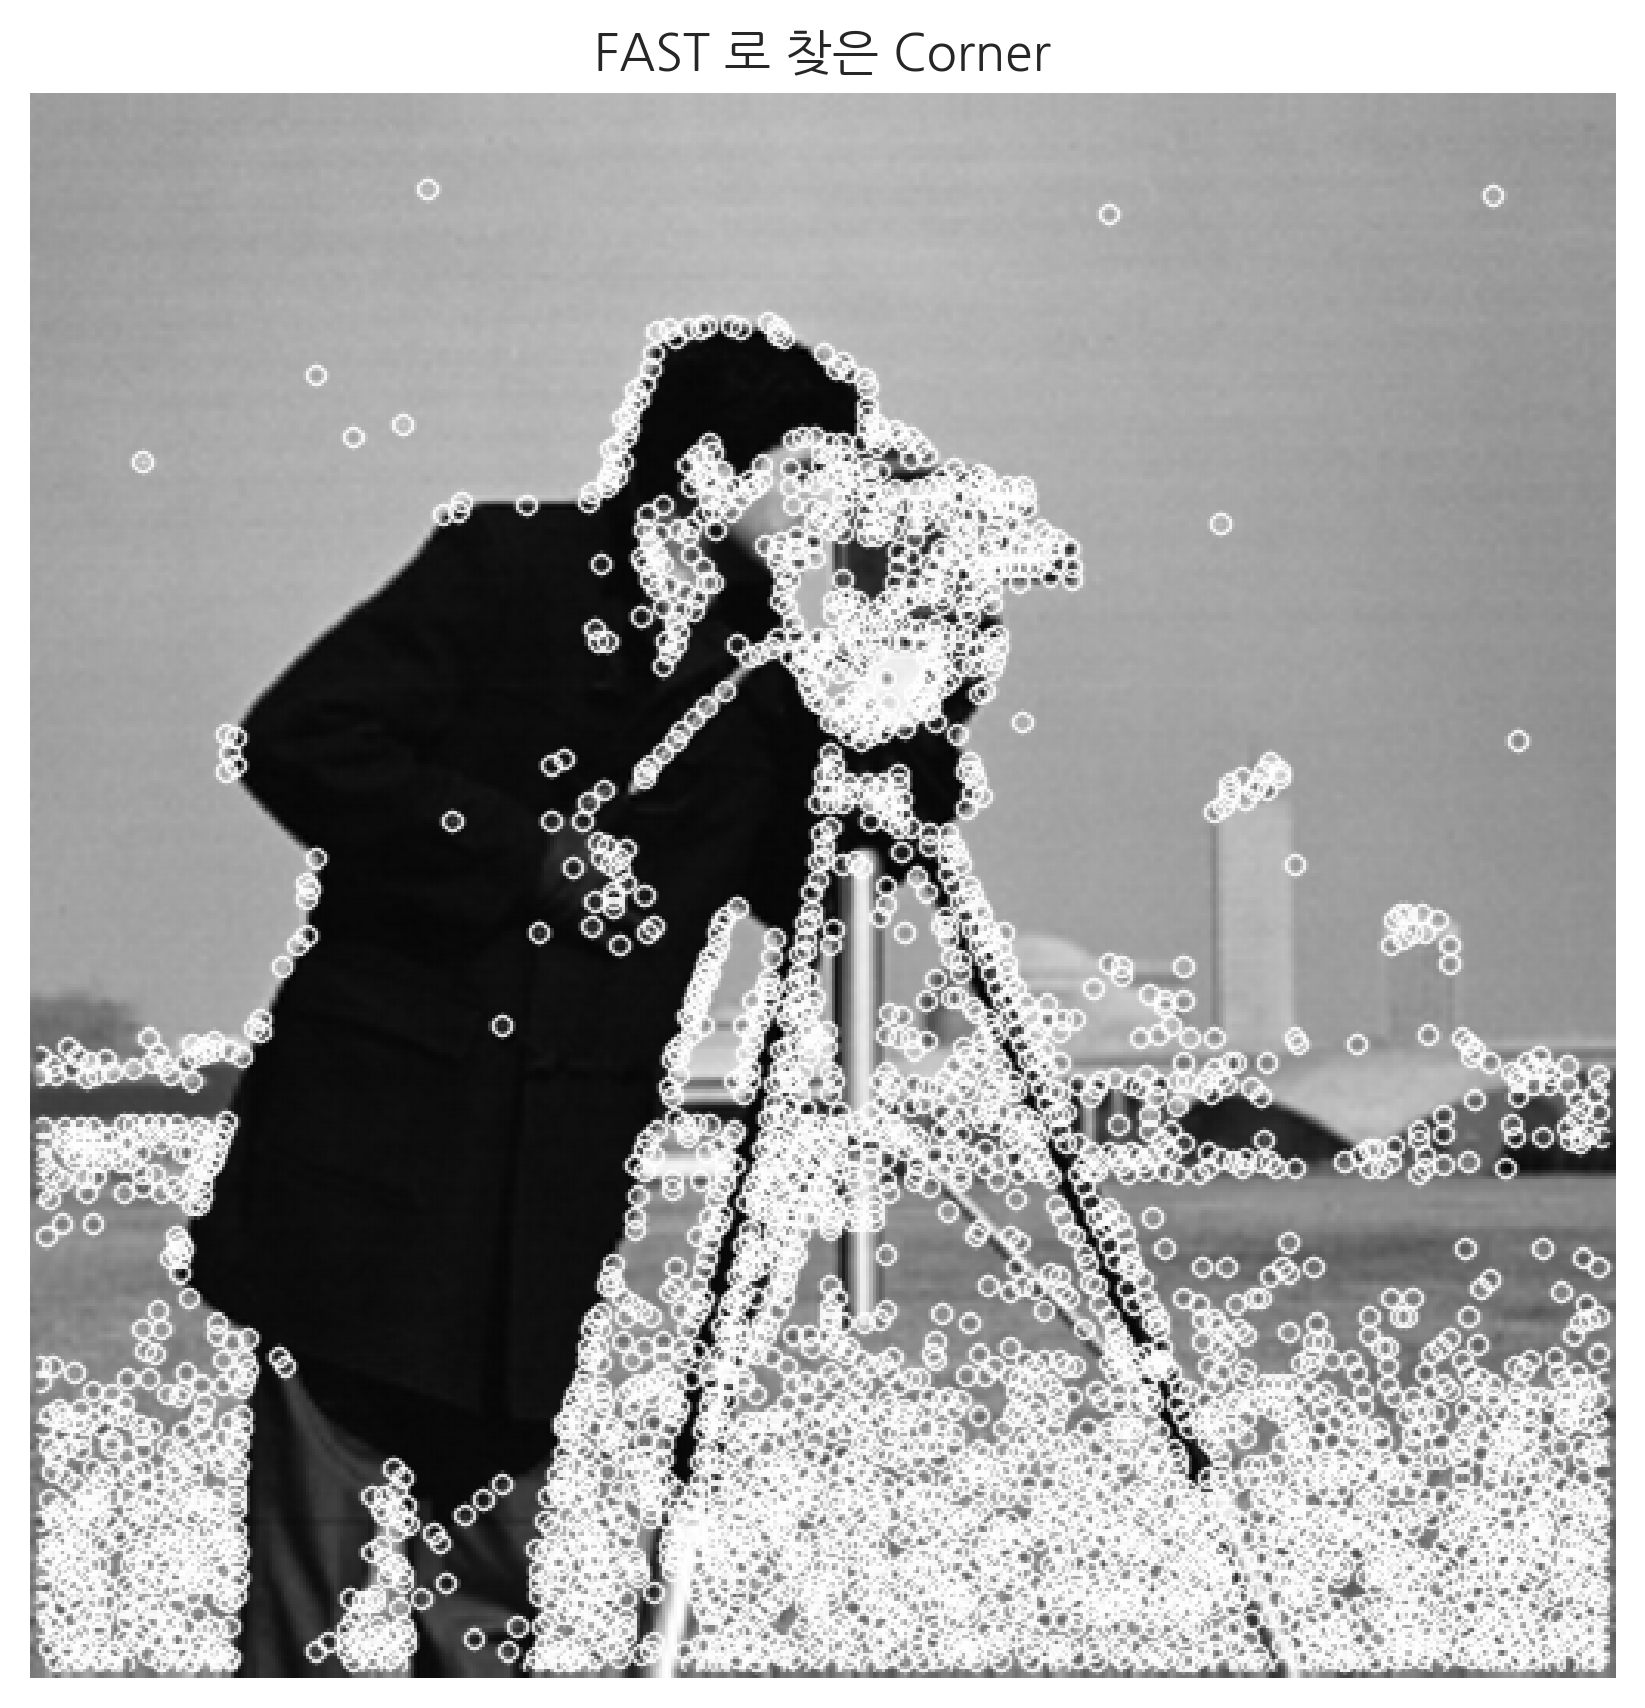

In [15]:
fast = cv2.FastFeatureDetector_create()
kps = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kps, img, color=(255, 255, 255))

print("기준값: ", fast.getThreshold())
print("nonmaxSuppression: ", fast.getNonmaxSuppression())
print("nonmaxSuppression 후처리 후, 추출된 전체 특징점: ", len(kps))
plt.figure(figsize=(7,7))
plt.imshow(img2, cmap='gray')
plt.title("FAST 로 찾은 Corner")
plt.axis("off")
plt.show()

## ORB


ORB(Oriented FAST and Rotated BRIEF)는 위에서 배운 FAST 와 BRIEF를 기반으로 만들어진 알고리즘이다.

SIFT에서 하나의 특징점에 대한 정보(설명자)는 128차원의 실수 벡터이다. 이는 꽤 많은 메모리를 사용하고, 어쩌면 실제로 특징점을 매칭할 때, 모두 필요하지 않을 수도 있다. 이러한 잠재적인 리소스 낭비를 방지하기 위해서 BRIEF는 설명자 벡터를 특징점의 픽셀값을 기준으로 0, 1, 이진 값으로 나타낸다. BRIEF는 실제로 이미지에 매칭 하는 기능을 제공하는 것이 아니라, 이미지를 매칭할 때 사용되는 메모리를 절약하기 위한 설명자 표현법이다. 

1. 먼저, FAST로 특징점을 찾고, 
2. Harris corner dectection에서 사용하는 코너에 대한 정량적인 값을 기준으로 가장 코너성이 큰 $N$개의 코너를 선택한다. 
3. SIFT에서 설명한 스케일 피라미드를 만들어 똑같이 특징점을 추출하고 여러 스케일에 대한 특징점을 찾는다. 
4. 다음으로 찾아낸 코너의 방향을 알기 위해서, 한 윈도우 안에서 Intesity Centroid라는 것을 계산 한다. 특징으로 추출된(코너) 픽셀을 중심으로 윈도우를 형성하고, 중심에 있는 코너로 부터 계산한 Intesity Centroid의 방향이 코너의 방향성을 대변한다.
5. 설명자로 BRIEF를 사용하고자 했지만, BRIEF는 방향에 대한 정보를 가지지 않기 때문에, steer-BRIEF라는 것을 사용한다. 
6. 또한, steer-BRIEF는 벡터의 분산값이 작기 때문에, 평균은 그대로 두고, 높은 분산값을 가지게 하는 과정을 거친다. 이렇게 많든 BRIEF를 rBRIEF 라고 한다. 
7. 실제로 이미지를 매칭할 때는 multi-probe LSH(Locality Sensetive Hashing)를 사용한다. 

논문에서는 SURF와 SIFT보다 매우 빠르고, SURF 보다 정확한, 낮은 컴퓨팅 파워 환경에서 돌리기에 좋은 알고리즘이라 소개 한다. 다음 코드는 이미지에 대해 `ORB` 특징을 찾고, 변환된 이미지에서 같은 특징점 끼리 매칭하는 작업을 수행한다. 

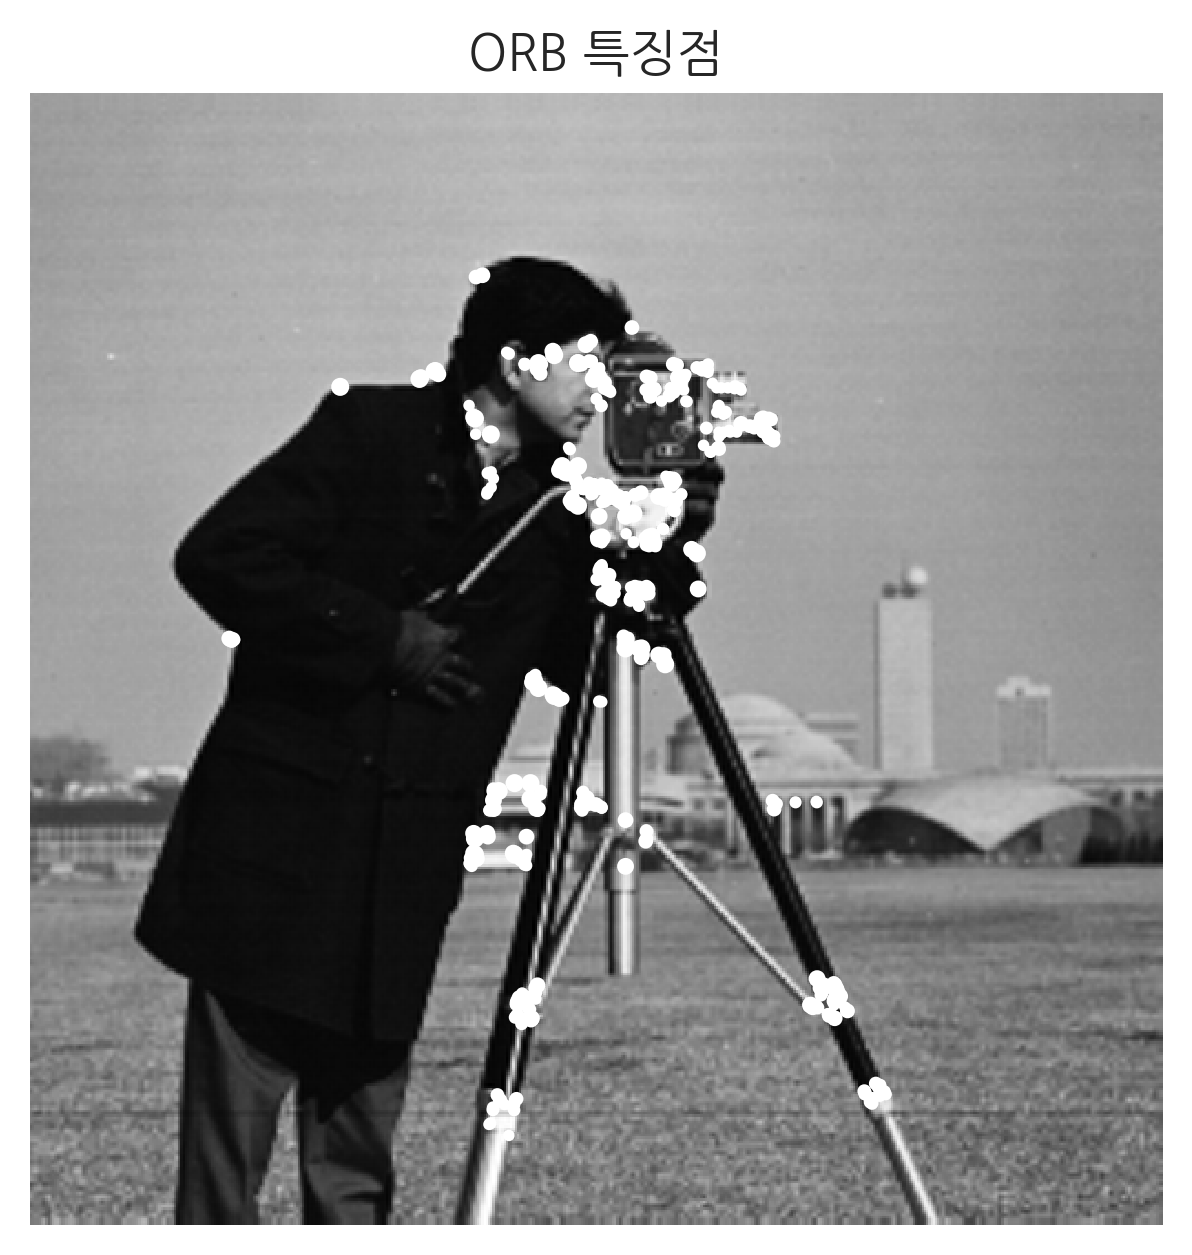

In [16]:
orb = cv2.ORB_create()
kps, des = orb.detectAndCompute(img, None)
kps_r, des_r = orb.detectAndCompute(img_rotated, None)

bf = cv2.BFMatcher_create()
matches = bf.knnMatch(des, des_r, k=2)

good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

np.random.shuffle(good)
image_match = cv2.drawMatchesKnn(
    img, kps, img_rotated, kps_r, good[:10], flags=2, outImg=img)

pts_x = [kp.pt[0] for kp in kps]
pts_y = [kp.pt[1] for kp in kps]
pts_s = [kp.size / 10 for kp in kps]


plt.imshow(img, cmap='gray')
plt.title("ORB 특징점")
plt.axis("off")
plt.scatter(pts_x, pts_y, s=pts_s, c="w")
plt.show()

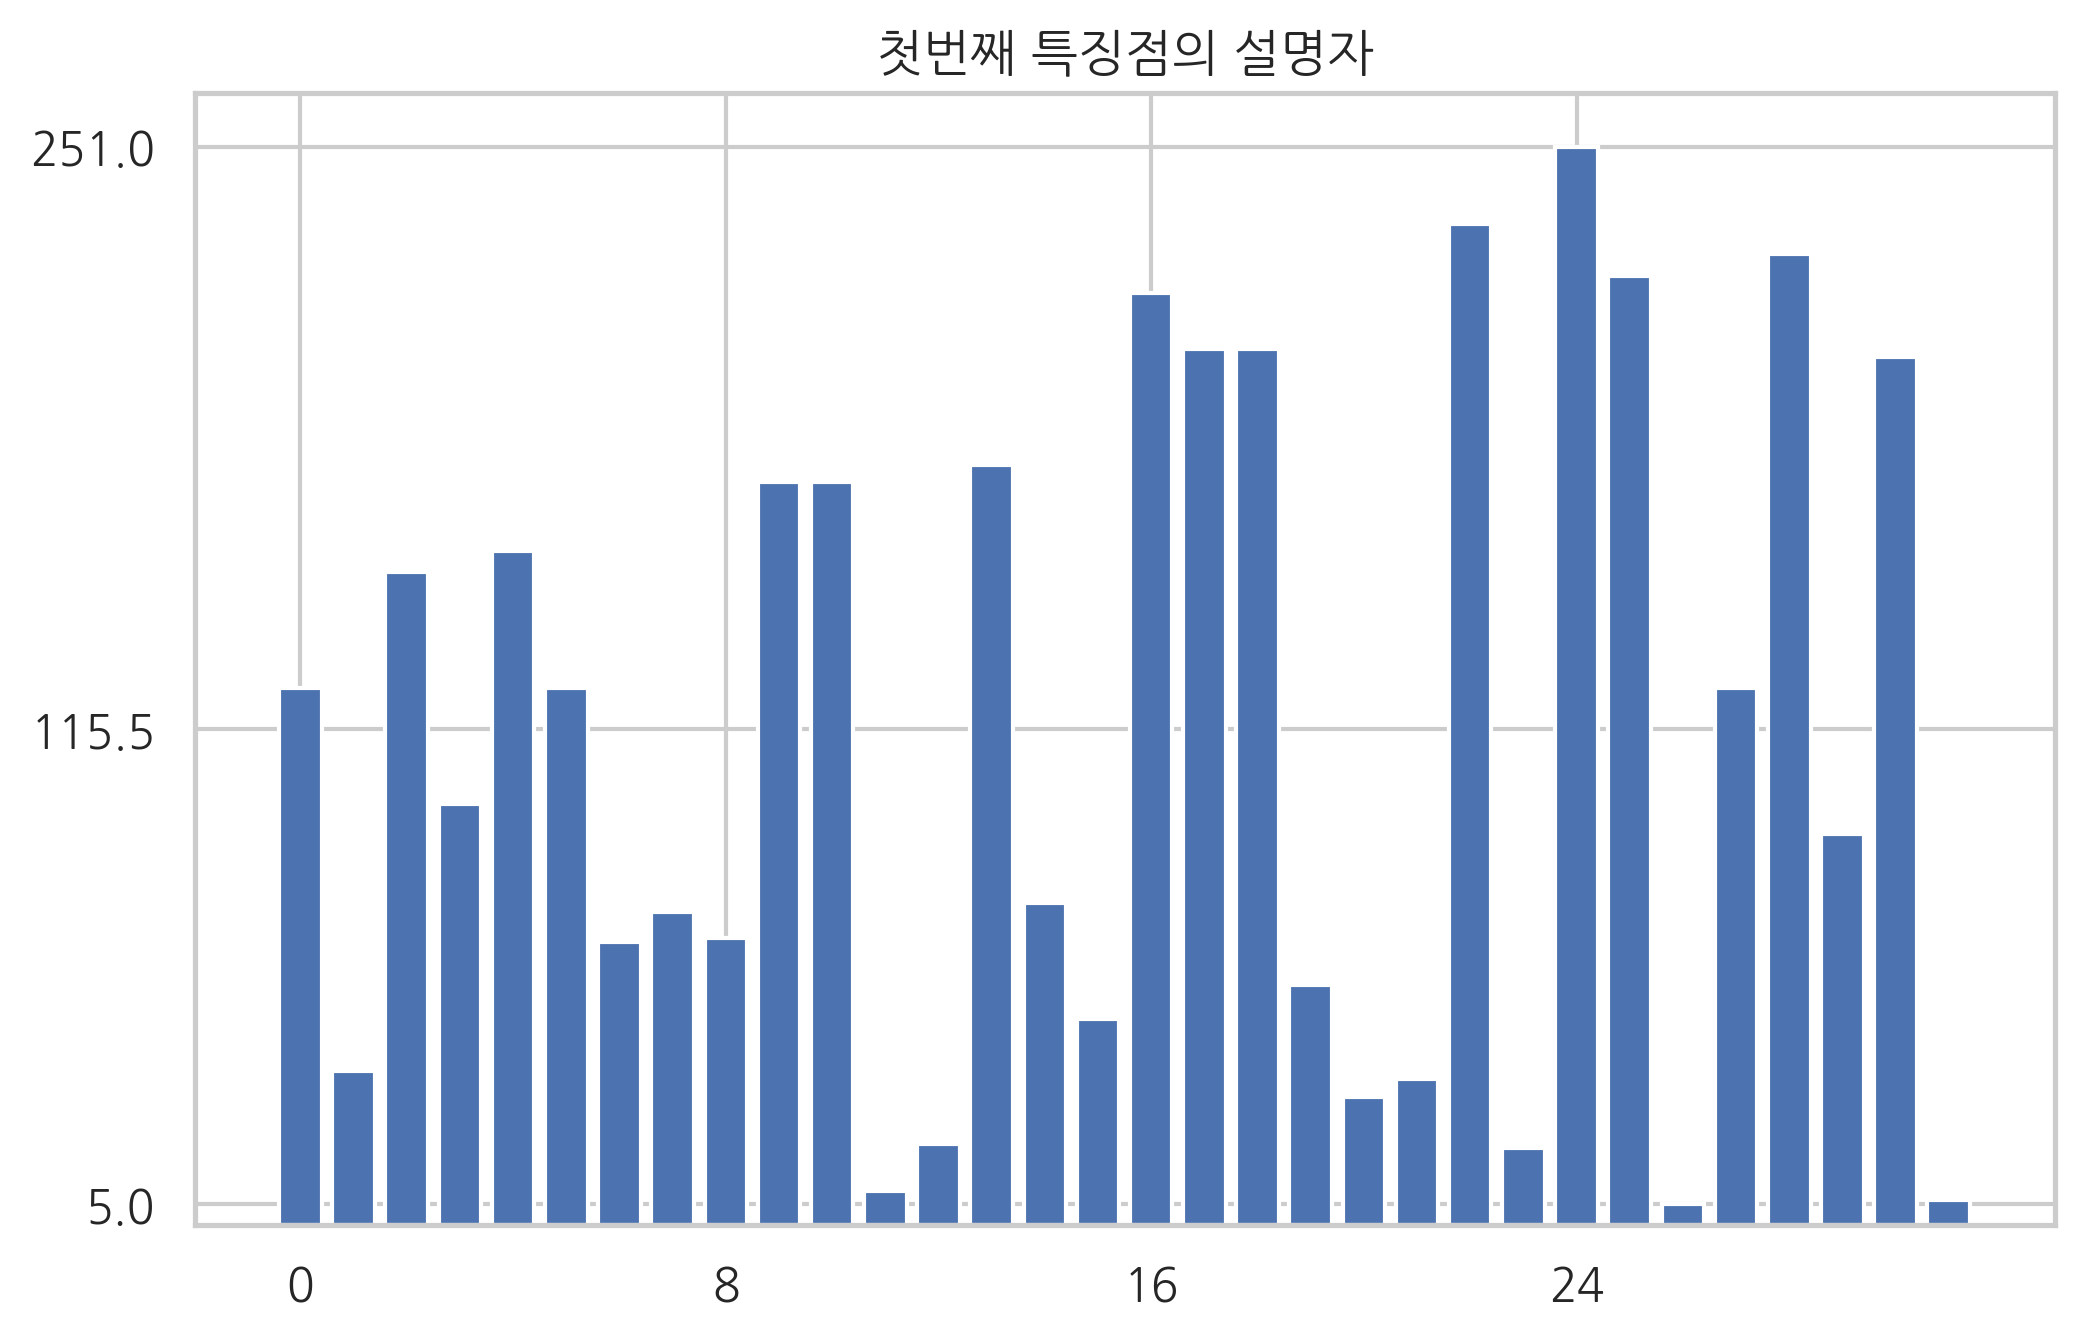

In [17]:
plt.bar(np.arange(len(des[0])), des[0])
plt.xticks(range(0, len(des[0]), 8))
plt.yticks([des[0].min(), des[0].mean(), des[0].max()])
plt.title("첫번째 특징점의 설명자")
plt.show()

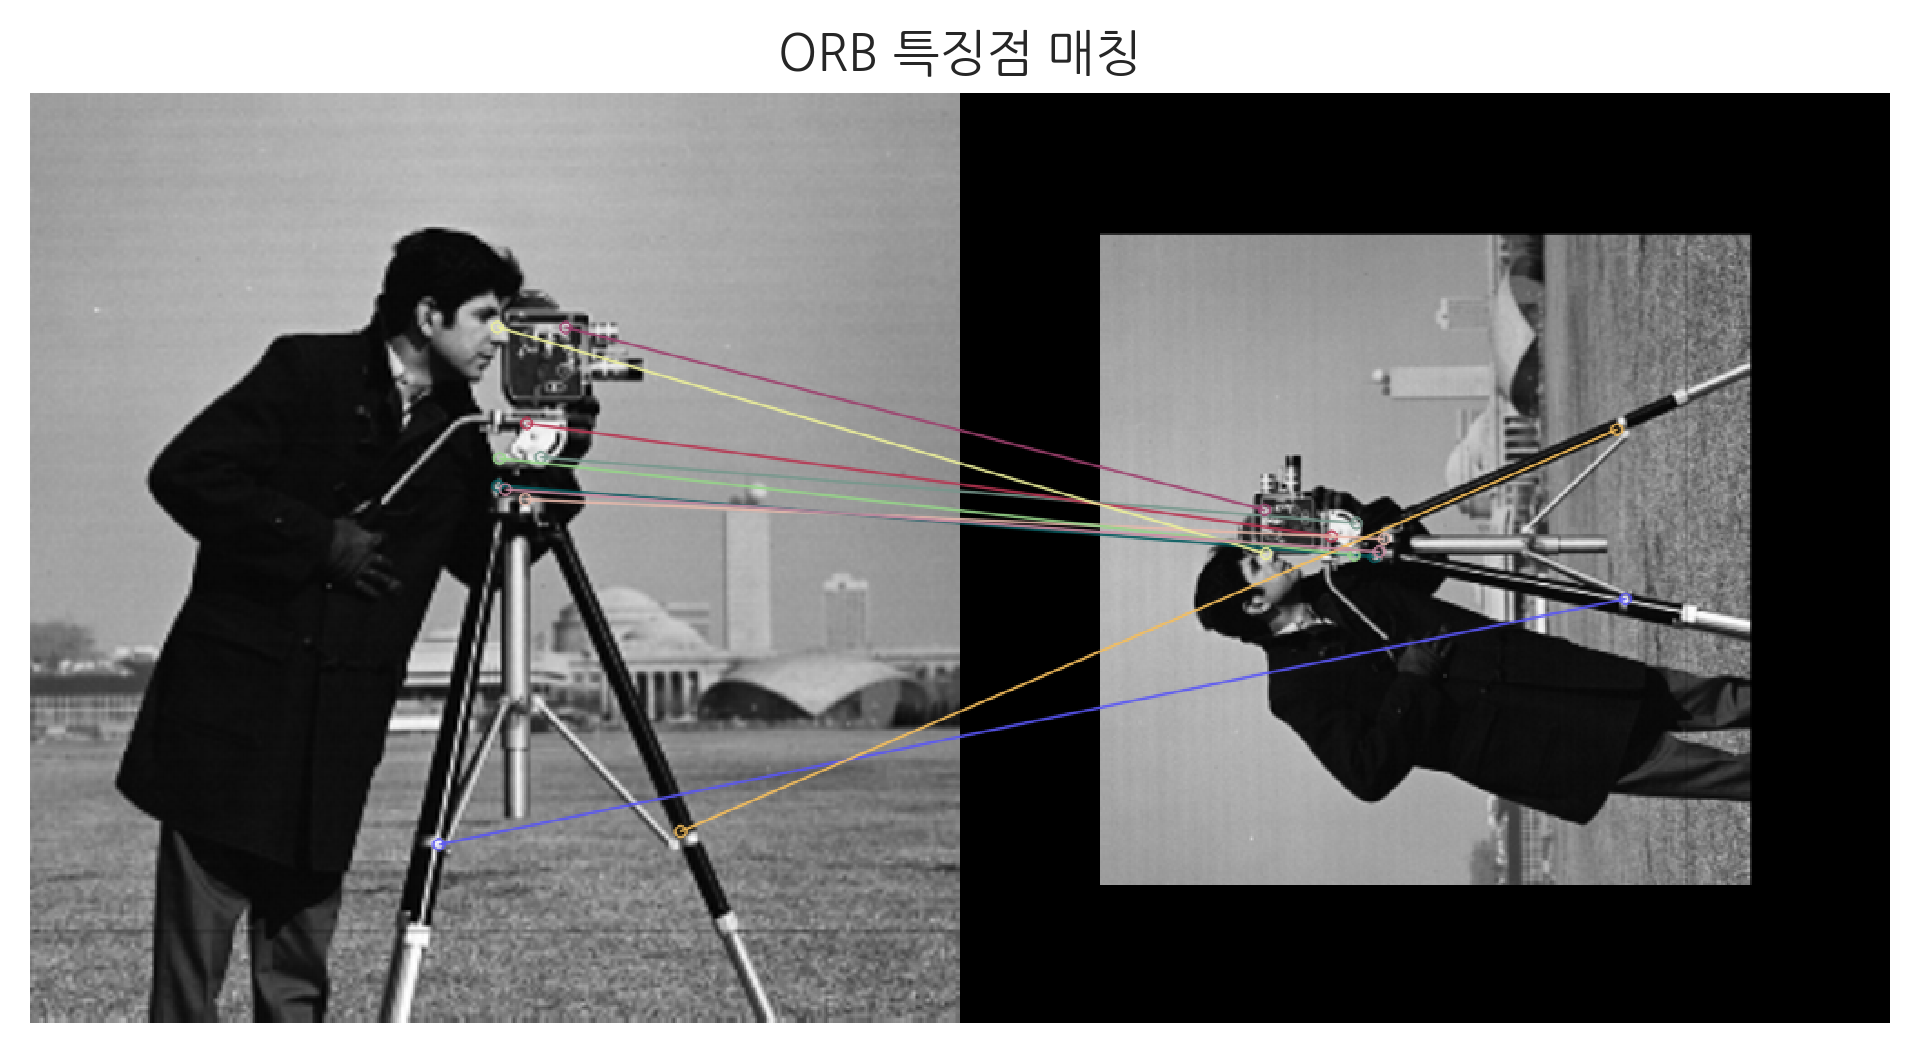

In [18]:
plt.imshow(image_match)
plt.title("ORB 특징점 매칭")
plt.axis("off")
plt.show()